In [1]:
from time import time
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit import transpile, ClassicalRegister
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit.visualization import plot_histogram
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.ibmq.managed import IBMQJobManager

from utilities import startup, bit_str_list, run_cal
from teleportation import Teleportation, calc_teleported_negativities, plot_teleported_negativities_multi_gap
from entanglebase import EntangleBase

provider = startup(hub='ibm-q-melbourne', group='unimelb', project='hub')
backend = provider.get_backend('ibm_algiers')
#backend = provider.backend.ibmq_mumbai

In [1]:
from qiskit.visualization import plot_error_map
from utilities import IBM_startup
hub = "ibm-q-melbourne"
group = "unimelb"
project = "hub"
backend_name = 'ibm_sherbrooke'
hgp = f"{hub}/{group}/{project}"

#provider = IBMProvider()
provider = IBM_startup()
backend = provider.get_backend(backend_name, instance=hgp)
plot_error_map(backend)

Account enabled


MissingOptionalLibraryError: "The 'seaborn' library is required to use 'plot_error_map'. You can install it with 'pip install seaborn'."

In [1]:
from time import time
import json
import pickle
import copy
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import networkx as nx
from itertools import islice
from qiskit import transpile, ClassicalRegister
from qiskit.quantum_info import partial_trace, Statevector, DensityMatrix, Operator
from qiskit_ibm_provider import IBMProvider
#from qiskit.providers.ibmq.managed import IBMQJobManager
from utilities import IBM_startup, bit_str_list, run_cal, load_cal
from teleportation import Teleportation, calc_negativities, calc_n_mean, calc_teleported_negativities, plot_teleported_negativities_multi_gap, teleported_negativities_multi_gap_data

hub = "ibm-q-melbourne"
group = "unimelb"
project = "hub"
backend_name = 'ibm_torino'
hgp = f"{hub}/{group}/{project}"

#provider = IBMProvider()
provider = IBM_startup()
backend = provider.get_backend(backend_name, instance=hgp)
#backend = provider.backend.ibmq_mumbai
#provider = startup()

def take(n, iterable):
    """Return the first n items of the iterable as a list."""
    return list(islice(iterable, n))

Account enabled


Test optimal paths/chains for Teleportation

In [ ]:
Long_chain = Teleportation(backend, qubits_to_connect=list(range(133)))
shots = 8192
#shots=8192
job = Long_chain.run_qst(reps=4, shots=shots, qrem=True, execute_only=True)
print("Device:", backend.name, f'({len(backend.properties().qubits)} qubits)')
print("Job ID:", job.job_id())
result = job.result()
print('job completed, result obtained')

rho_dict_mit, rho_dict = Long_chain.qst_from_result(result, 'all')
n_list = calc_negativities(rho_dict, mode='mean')
nmit_list = calc_negativities(rho_dict_mit, mode='mean')

In [2]:
Long_chain = Teleportation(backend, qubits_to_connect=list(range(133)))
job = provider.backend.retrieve_job('cpbsasvprheg008rrsv0')
result = job.result()

rho_dict_mit, rho_dict = Long_chain.qst_from_result(result, 'all')
n_list = calc_negativities(rho_dict, mode='mean')
nmit_list = calc_negativities(rho_dict_mit, mode='mean')

try:
    n_list[0]
except:
    n_list = [n_list]
    nmit_list = [nmit_list]
edges = n_list[0].keys()
n_mean, n_std = calc_n_mean(n_list)
nmit_mean, nmit_std = calc_n_mean(nmit_list)

#extract the best chain for teleportation
error_graph = Long_chain.graph
n_graph = nx.Graph()
nmit_graph = nx.Graph()
for edge, neg in n_mean.items():
    n_graph.add_edge(edge[0], edge[1], weight=neg)
for edge, neg in nmit_mean.items():
    nmit_graph.add_edge(edge[0], edge[1], weight=neg)

In [3]:
#iterate over all possible gaps, find best chain for each gap (highest negativity)
best_paths_CXerr = {}
best_paths_n = {}
best_paths_nmit = {}
Long_chain.gen_teleportation_basis()
print('teleportation basis generated')
for gap in range(1,15):
    avaliable_paths = Long_chain.teleportation_basis[gap]
    best_path_CXerr = None
    best_path_n = None
    best_path_nmit = None
    best_err = 1
    best_n = 0
    best_nmit = 0
    for pair in avaliable_paths.keys():
        path = nx.shortest_path(error_graph, pair[0], pair[1], weight = 1)
        net_err = 1
        net_n = 1
        net_nmit = 1
        for i in range(len(path)-1):
            net_err *= error_graph.get_edge_data(path[i], path[i+1])['weight']
            net_n *= n_graph.get_edge_data(path[i], path[i+1])['weight']
            net_nmit *= nmit_graph.get_edge_data(path[i], path[i+1])['weight']
        if net_err < best_err:
            best_path_CXerr = path.copy()
            best_err = net_err
        if net_n > best_n:
            best_path_n = path.copy()
            best_n = net_n
        if net_nmit > best_nmit:
            best_path_nmit = path.copy()
            best_nmit = net_nmit
    best_paths_CXerr[gap] = (best_err, sorted(best_path_CXerr))
    best_paths_n[gap] = (best_n, sorted(best_path_n))
    best_paths_nmit[gap] = (best_nmit, sorted(best_path_nmit))
    
    print(f'gap {gap} has best path {best_path_CXerr} with least net CNOT errors: {best_err}')
    print(f'gap {gap} has best path {best_path_n} with highest negativity: {best_n}')
    print(f'gap {gap} has best path {best_path_nmit} with highest mitigated negativity: {best_nmit}')

#dump the optimal paths data to local paths
with open('optimal paths/CX_err_optimal_paths_2023_12_21.pkl', 'wb') as file:
    #file.write(json.dumps(best_paths_CXerr))
    pickle.dump(best_paths_CXerr, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('optimal paths/negativity_optimal_paths_2023_12_21.pkl', 'wb') as file:
    #ile.write(json.dumps(best_paths_n))
    pickle.dump(best_paths_n, file, protocol=pickle.HIGHEST_PROTOCOL)
with open('optimal paths/negativity_mitigated_optimal_paths_2023_12_21.pkl', 'wb') as file:
    #file.write(json.dumps(best_paths_nmit))
    pickle.dump(best_paths_nmit, file, protocol=pickle.HIGHEST_PROTOCOL)

teleportation basis generated
gap 1 has best path [87, 88, 94] with least net CNOT errors: 3.3126370405575776e-06
gap 1 has best path [12, 13, 14] with highest negativity: 0.15503502790297907
gap 1 has best path [34, 40, 39] with highest mitigated negativity: 0.24727653391793106
gap 2 has best path [86, 87, 88, 94] with least net CNOT errors: 8.262308376633942e-09
gap 2 has best path [11, 12, 13, 14] with highest negativity: 0.058296276547023095
gap 2 has best path [106, 107, 108, 109] with highest mitigated negativity: 0.11951132860352576
gap 3 has best path [87, 88, 94, 107, 108] with least net CNOT errors: 1.9476937884516355e-11
gap 3 has best path [10, 11, 12, 13, 14] with highest negativity: 0.02189826691687805
gap 3 has best path [68, 69, 70, 71, 75] with highest mitigated negativity: 0.05839255013974813
gap 4 has best path [86, 87, 88, 94, 107, 108] with least net CNOT errors: 4.8578961432892727e-14
gap 4 has best path [44, 43, 42, 54, 61, 62] with highest negativity: 0.00765438

{1: {(0, 4): {'X': [1], 'Z': []}}}
{1: {(0, 4): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED19C0>}}
{1: {(0, 4): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED19C0>}}
{1: {(0, 4): {'XX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142FB2E3910>, 'XY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED3E50>, 'XZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED3850>, 'YX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED12D0>, 'YY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED0040>, 'YZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED2C20>, 'ZX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED0520>, 'ZY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED3DF0>, 'ZZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000142F8ED2740>}}}
['1-(0, 4)-XX', '1-(

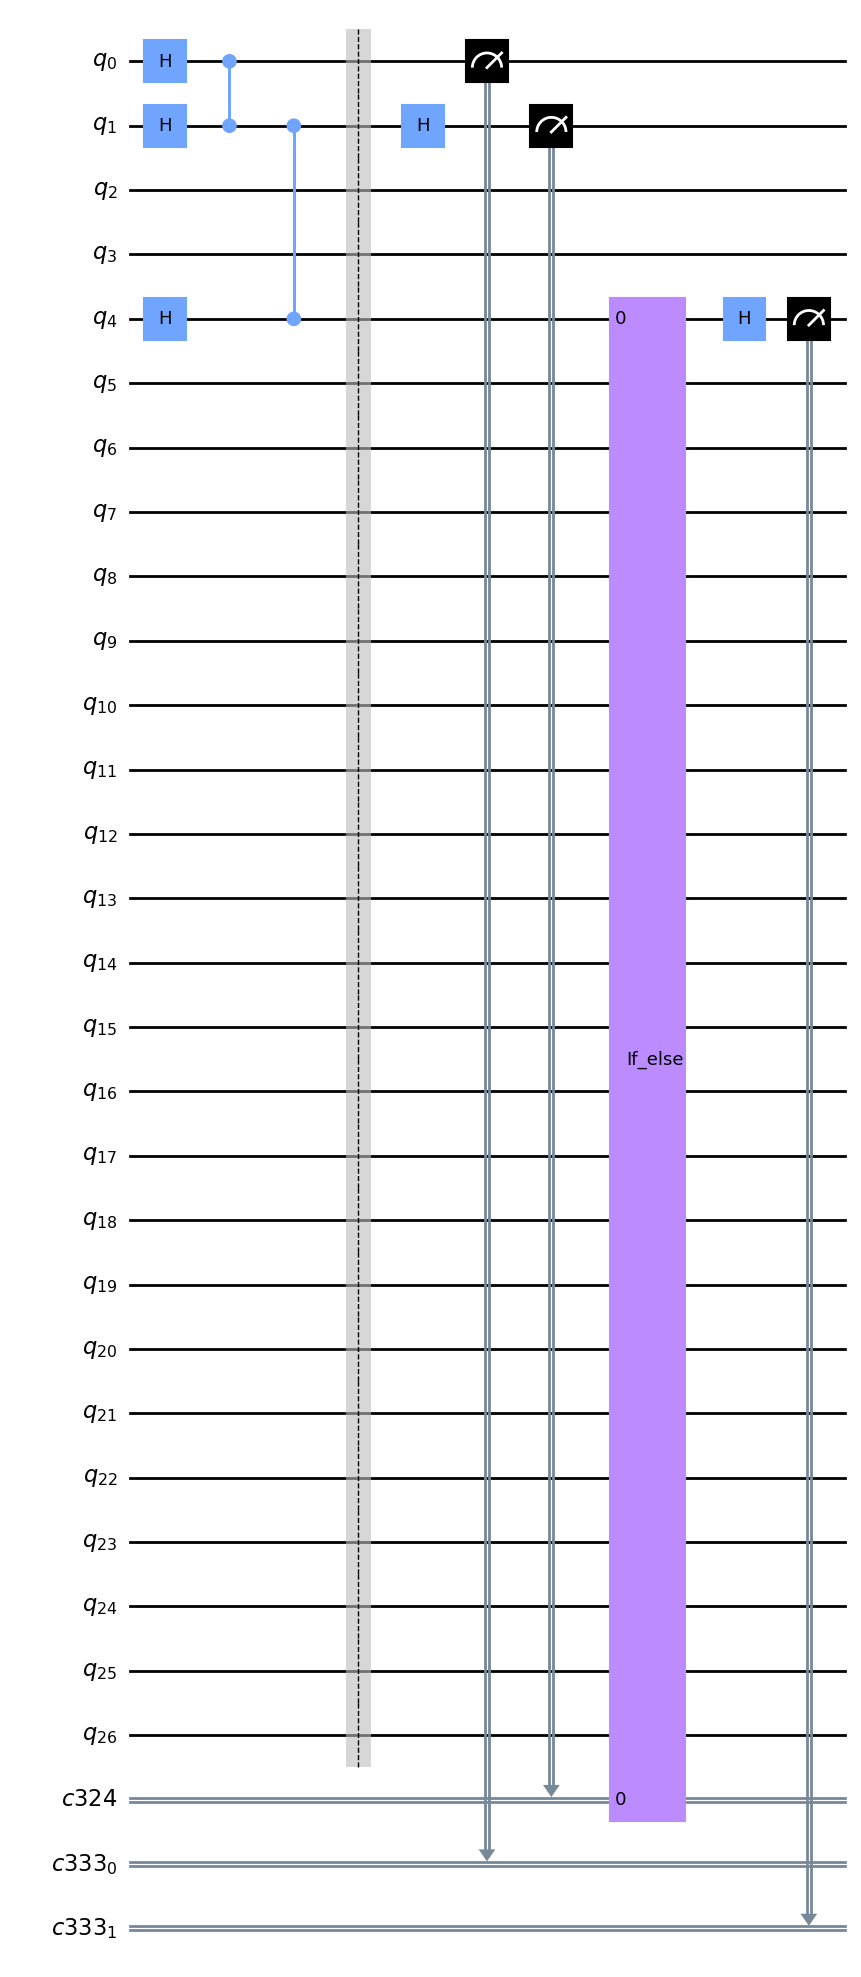

In [14]:
#backend = provider.get_backend('ibm_oslo')
test = Teleportation(backend, qubits_to_connect=[0,1,4])
test.gen_teleportation_basis()
print(test.teleportation_basis)
test.gen_teleported_BellState_circuit(post_processing = False)
print(test.teleported_BellState_circuits)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
print(test.teleported_BellState_circuits)
test.gen_teleported_qst_circuits()
print(test.teleported_BellState_circuits_qst)
print(test.name_list)

test.teleported_BellState_circuits_qst[1][(0,4)]['ZZ'].draw('mpl')

#job = test.run_teleported_qst_circuits(reps=1, shots=8192, qrem=False, sim='ideal')
#print(len(job.result().results))
#print(job.result().get_counts('3-(0, 4)-ZZ-0'))

#rho_dict_list = test.recon_teleported_density_mats(job.result(), post_processing= False, apply_mit = False)
#print(rho_dict_list[0][1][(0,2)])
#n_list = calc_teleported_negativities(rho_dict_list, post_processing = False, mode = 'all')
#print(n_list[0][1][(0,2)])

#qst_counts, qst_pvecs = test.teleported_counts_from_result(job.result(), post_processing = False)
#print(qst_counts[0][3][(0,4)]['ZZ'])
#print(qst_pvecs[0][3][(0,4)]['ZZ'])

#qst_counts_mit, qst_pvecs_mit = test.apply_qrem_teleported_counts(qst_counts, qst_pvecs)
#print(qst_counts_mit[0][3][(0,4)]['ZZ'])
#print(qst_pvecs_mit[0][3][(0,4)]['ZZ'])

#pvecs_binned = test.bin_teleported_pvecs_from_dynamic_circuits(qst_counts, qst_pvecs)
#print(pvecs_binned[0][3][(0,4)]['ZZ'])

In [26]:
from qiskit.visualization import circuit_drawer
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,2,3,4])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
print(test.teleported_BellState_circuits)
test.gen_teleported_qst_circuits()
print(test.teleported_BellState_circuits_qst)
print(test.name_list)
print(len(test.name_list))
print(circuit_drawer(test.teleported_BellState_circuits_qst[3][(0,4)]['ZZ'], output = 'latex_source'))
#job,job_qrem = test.run_teleported_qst_circuits(reps=1, shots=4096, qrem=True, sim='ideal')
#print('job done')
#result = job.result()
#result_qrem = job_qrem.result()
#print(f'job 1: {job1.job_id()}')

{3: {(0, 4): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000230896693F0>}}
{3: {(0, 4): {'XX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002308E086C50>, 'XY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000230906F23E0>, 'XZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000230896684C0>, 'YX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x0000023089668A30>, 'YY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000230956EA8C0>, 'YZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002308FE19030>, 'ZX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000230FC4418A0>, 'ZY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002308F9F1270>, 'ZZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000002308FC55EA0>}}}
['3-(0, 4)-XX', '3-(0, 4)-XY', '3-(0, 4)-XZ', '3-(0, 4)-YX', '3-(0, 4)-YY', '3-(0, 4)-YZ', '3-(0, 4)-ZX', '3-(0, 4)-ZY', '3-(0, 4)-ZZ']
9
\documen

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
print(test.teleported_BellState_circuits)
test.gen_teleported_qst_circuits()
print(test.teleported_BellState_circuits_qst)
print(test.name_list)
print(len(test.name_list))
job,job_qrem = test.run_teleported_qst_circuits(reps=1, shots=4096, qrem=True, sim='ideal')
print('job done')
result = job.result()
result_qrem = job_qrem.result()
#print(f'job 1: {job1.job_id()}')

{1: {(0, 4): <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C37EF50>}}
{1: {(0, 4): {'XX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C37F430>, 'XY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C37DB40>, 'XZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F5210>, 'YX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F52D0>, 'YY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F5540>, 'YZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F57E0>, 'ZX': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F5A80>, 'ZY': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F5480>, 'ZZ': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x000001F97C3F4370>}}}
['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ']
9
job done

In [3]:
rho_dict_list = test.recon_teleported_density_mats(result, result_qrem, post_processing=False, apply_mit=False)
rho_dict_list_mit = test.recon_teleported_density_mats(result, result_qrem, post_processing=False, apply_mit=True)
n_list = calc_teleported_negativities(rho_dict_list, post_processing = False, mode='mean')
nmit_list = calc_teleported_negativities(rho_dict_list_mit, post_processing = False, mode='mean')
print(n_list)
print(nmit_list)

[{1: {(0, 4): 0.49387899274467156}}]
[{1: {(0, 4): 0.49387899274467156}}]


Dynamic Circuits jobs submission

In [ ]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
#test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
print(test.teleported_BellState_circuits)
test.gen_teleported_qst_circuits()
print(test.teleported_BellState_circuits_qst)
print(test.name_list)
print(len(test.name_list))
test.teleported_BellState_circuits_qst[2][(0,7)]['ZZ'].draw()
#test.teleported_BellState_circuits_qst[8][(0,23)]['ZZ'].draw()
#job1,job_qrem = test.run_teleported_qst_circuits(reps=8, shots=4096, qrem=True, sim=None)
#print(job_qrem.job_id())
#print(job1.job_id())

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend,
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job9,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job10,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job11,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job 9: {job9.job_id()}')
print(f'job 10: {job10.job_id()}')
print(f'job 11: {job11.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 15)-XX', '1-(10, 15)-XY', '1-(10, 15)-XZ', '1-(10, 15)-YX', '1-(10, 15)-YY', '1-(10, 15)-YZ', '1-(10, 15)-ZX', '1-(10, 15)-ZY', '1-(10, 15)-ZZ', '1-(12, 18)-XX', '1-(12, 18)-XY', '1-(12, 18)-XZ', '1-(12, 18)-YX', '1-(12, 18)-YY', '1-(12, 18)-YZ', '1-(12, 18)-ZX', '1-(12, 18)-ZY', '1-(12, 18)-ZZ', '1-(15, 21)-XX', '1-(15, 21)-XY', '1-(15, 21)-XZ', '1-(15, 21)-YX', '1-(15, 21)-YY', '1-(15, 21)-YZ', '1-(15, 21)-ZX', '1-(15, 21)-ZY',

Dynamic Circuits (14 gap/ ibm_algeirs)

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend,
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job9,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job10,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job11,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job12,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job13,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job14,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job 9: {job9.job_id()}')
print(f'job 10: {job10.job_id()}')
print(f'job 11: {job11.job_id()}')
print(f'job 12: {job12.job_id()}')
print(f'job 13: {job13.job_id()}')
print(f'job 14: {job14.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 13)-XX', '1-(10, 13)-XY', '1-(10, 13)-XZ', '1-(10, 13)-YX', '1-(10, 13)-YY', '1-(10, 13)-YZ', '1-(10, 13)-ZX', '1-(10, 13)-ZY', '1-(10, 13)-ZZ', '1-(12, 14)-XX', '1-(12, 14)-XY', '1-(12, 14)-XZ', '1-(12, 14)-YX', '1-(12, 14)-YY', '1-(12, 14)-YZ', '1-(12, 14)-ZX', '1-(12, 14)-ZY', '1-(12, 14)-ZZ', '1-(13, 16)-XX', '1-(13, 16)-XY', '1-(13, 16)-XZ', '1-(13, 16)-YX', '1-(13, 16)-YY', '1-(13, 16)-YZ', '1-(13, 16)-ZX', '1-(13, 16)-ZY',

Dynamic circuit ibm_hanoi 14 gaps

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend,
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,14,15,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job9,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job10,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job11,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job12,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job13,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job14,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job 9: {job9.job_id()}')
print(f'job 10: {job10.job_id()}')
print(f'job 11: {job11.job_id()}')
print(f'job 12: {job12.job_id()}')
print(f'job 13: {job13.job_id()}')
print(f'job 14: {job14.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 15)-XX', '1-(10, 15)-XY', '1-(10, 15)-XZ', '1-(10, 15)-YX', '1-(10, 15)-YY', '1-(10, 15)-YZ', '1-(10, 15)-ZX', '1-(10, 15)-ZY', '1-(10, 15)-ZZ', '1-(12, 18)-XX', '1-(12, 18)-XY', '1-(12, 18)-XZ', '1-(12, 18)-YX', '1-(12, 18)-YY', '1-(12, 18)-YZ', '1-(12, 18)-ZX', '1-(12, 18)-ZY', '1-(12, 18)-ZZ', '1-(15, 21)-XX', '1-(15, 21)-XY', '1-(15, 21)-XZ', '1-(15, 21)-YX', '1-(15, 21)-YY', '1-(15, 21)-YZ', '1-(15, 21)-ZX', '1-(15, 21)-ZY',

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 15)-XX', '1-(10, 15)-XY', '1-(10, 15)-XZ', '1-(10, 15)-YX', '1-(10, 15)-YY', '1-(10, 15)-YZ', '1-(10, 15)-ZX', '1-(10, 15)-ZY', '1-(10, 15)-ZZ', '1-(12, 18)-XX', '1-(12, 18)-XY', '1-(12, 18)-XZ', '1-(12, 18)-YX', '1-(12, 18)-YY', '1-(12, 18)-YZ', '1-(12, 18)-ZX', '1-(12, 18)-ZY', '1-(12, 18)-ZZ', '1-(15, 21)-XX', '1-(15, 21)-XY', '1-(15, 21)-XZ', '1-(15, 21)-YX', '1-(15, 21)-YY', '1-(15, 21)-YZ', '1-(15, 21)-ZX', '1-(15, 21)-ZY',

Swap Teleportation Job submission

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.gen_teleported_qst_circuits()
job, job_qrem = test.run_teleported_qst_circuits(reps=2, shots=8192, qrem=True, sim=None)
print(f'job: {job.job_id()}')
print(f'qrem job: {job_qrem.job_id()}')

job: chlfssiae4cj9gc7drl0
qrem job: chlfslc6f7i49rqcdqa0


Swap Teleportation Job submission (ibm_algiers/14 gap)

In [2]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend,
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job9,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job10,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job11,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job12,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job13,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job14,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job 9: {job9.job_id()}')
print(f'job 10: {job10.job_id()}')
print(f'job 11: {job11.job_id()}')
print(f'job 12: {job12.job_id()}')
print(f'job 13: {job13.job_id()}')
print(f'job 14: {job14.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 13)-XX', '1-(10, 13)-XY', '1-(10, 13)-XZ', '1-(10, 13)-YX', '1-(10, 13)-YY', '1-(10, 13)-YZ', '1-(10, 13)-ZX', '1-(10, 13)-ZY', '1-(10, 13)-ZZ', '1-(12, 14)-XX', '1-(12, 14)-XY', '1-(12, 14)-XZ', '1-(12, 14)-YX', '1-(12, 14)-YY', '1-(12, 14)-YZ', '1-(12, 14)-ZX', '1-(12, 14)-ZY', '1-(12, 14)-ZZ', '1-(13, 16)-XX', '1-(13, 16)-XY', '1-(13, 16)-XZ', '1-(13, 16)-YX', '1-(13, 16)-YY', '1-(13, 16)-YZ', '1-(13, 16)-ZX', '1-(13, 16)-ZY',

Post-processing job submission

In [3]:
#gap = 11
#test = Teleportation(backend, 
#                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])

#post-processed for gap = 14
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,2,3,5,8,11,14,16,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)

#bs_circuits = {gap:{} for gap in range(1,15)}
#for gap, pairs_dict in test.teleported_BellState_circuits.items():
#    items = take(5, pairs_dict.items())
#    for pair, circ in items:
#        bs_circuits[gap][pair] = circ
#test.teleported_BellState_circuits = bs_circuits

test.gen_teleported_qst_circuits()
circ_list = []
for pairs_dict in test.teleported_BellState_circuits_qst.values():
    for basis_dict in pairs_dict.values():
        for circuit in basis_dict.values():
            circ_list.append(circuit)

circ_list_multi = []
for i in range(4):
    for circ in circ_list:
        name_ext = circ.name + f'-{i}'
        circ_list_multi.append(circ.copy(name_ext))
circ_list = circ_list_multi
print(len(circ_list))
qrem_circuits = test.gen_qrem_circuits()
qrem_transpiled = transpile(qrem_circuits, backend = test.backend)
job_qrem = test.backend.run(qrem_transpiled, shots=8192)
print(job_qrem.job_id())

circ_list_transpiled = transpile(circ_list, backend = test.backend)
job = test.backend.run(circ_list_transpiled, shots=8192)#, dynamic = True)
#job = IBMCompositeJob(backend=test.backend, api_client=token, circuits_list=circ_list_transpiled)
print(job.job_id())

819
cnf023gbh0w0008y3seg
cnf02gtjpbeg008cwpt0


Post-Processed ibm_torino 14 gap

In [ ]:
#post-processed for gap = 14
########## Deprecacted?
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)

bs_circuits = {gap:{} for gap in range(1,15)}
for gap, pairs_dict in test.teleported_BellState_circuits.items():
    items = take(5, pairs_dict.items())
    for pair, circ in items:
        bs_circuits[gap][pair] = circ
test.teleported_BellState_circuits = bs_circuits

test.gen_teleported_qst_circuits()
circ_list = []
for pairs_dict in test.teleported_BellState_circuits_qst.values():
    for basis_dict in pairs_dict.values():
        for circuit in basis_dict.values():
            circ_list.append(circuit)

circ_list_multi = []
for i in range(2):
    for circ in circ_list:
        name_ext = circ.name + f'-{i}'
        circ_list_multi.append(circ.copy(name_ext))
circ_list = circ_list_multi
print(len(circ_list))
qrem_circuits = test.gen_qrem_circuits()
qrem_transpiled = transpile(qrem_circuits, backend = test.backend)
job_qrem = test.backend.run(qrem_transpiled, shots=8192)
print(job_qrem.job_id())

circ_list_transpiled = transpile(circ_list, backend = test.backend)
job = test.backend.run(circ_list_transpiled, shots=8192)#, dynamic = True)
#job = IBMCompositeJob(backend=test.backend, api_client=token, circuits_list=circ_list_transpiled)
print(job.job_id())

In [5]:
with open('optimal paths/CX_err_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_CXerr = pickle.load(file)
with open('optimal paths/negativity_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_n = pickle.load(file)
with open('optimal paths/negativity_mitigated_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_nmit = pickle.load(file)
print(best_paths_nmit)

for gap in range(1,15):
    test = Teleportation(backend, qubits_to_connect=best_paths_nmit[gap][1])
    test.gen_teleportation_basis()
    test.gen_teleported_BellState_circuit(post_processing = True)
    test.gen_teleported_qst_circuits()
    print(test.name_list)
    if gap == 1:
        job,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)
        print(f'job_qrem: {job_qrem.job_id()}')
        print(f'job{gap}: {job.job_id()}')
    else:
        job,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)
        print(f'job{gap}: {job.job_id()}')

{1: (0.24727653391793106, [34, 39, 40]), 2: (0.11951132860352576, [106, 107, 108, 109]), 3: (0.05839255013974813, [68, 69, 70, 71, 75]), 4: (0.02831652555849413, [105, 106, 107, 108, 109, 112]), 5: (0.013819800225075611, [105, 106, 107, 108, 109, 112, 124]), 6: (0.006478508961609721, [66, 67, 68, 69, 70, 71, 75, 90]), 7: (0.0031110745205930484, [3, 4, 16, 21, 22, 23, 34, 39, 40]), 8: (0.0014636645794673842, [55, 65, 66, 67, 68, 69, 70, 71, 75, 90]), 9: (0.0007158689268801944, [3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54]), 10: (0.00033867737222286284, [3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54, 61]), 11: (0.00016110977640472701, [3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54, 60, 61]), 12: (7.871540726198758e-05, [3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54, 59, 60, 61]), 13: (3.8249709575743404e-05, [3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54, 59, 60, 61, 72]), 14: (1.7769278672116367e-05, [2, 3, 4, 16, 21, 22, 23, 34, 40, 41, 42, 54, 59, 60, 61, 72])}


In [3]:
test = Teleportation(backend, 
                     qubits_to_connect=[34, 40, 39])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job1,job_qrem = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=True, sim=None)

test = Teleportation(backend,
                     qubits_to_connect=[106, 107, 108, 109])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job2,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[68, 69, 70, 71, 75])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job3,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[109, 108, 107, 106, 105, 112])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job4,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[109, 108, 107, 106, 105, 112, 124])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job5,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[66, 67, 68, 69, 70, 71, 75, 90])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job6,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 39])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job7,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[55, 65, 66, 67, 68, 69, 70, 71, 75, 90])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job8,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job9,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54, 61])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job10,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54, 61, 60])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job11,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54, 61, 60, 59])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job12,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54, 61, 60, 59, 72])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job13,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

test = Teleportation(backend, 
                     qubits_to_connect=[2, 3, 4, 16, 23, 22, 21, 34, 40, 41, 42, 54, 61, 60, 59, 72])
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
print(test.name_list)
job14,_ = test.run_teleported_qst_circuits(reps=4, shots=8192, qrem=False, sim=None)

print(f'job 1: {job1.job_id()}')
print(f'job 2: {job2.job_id()}')
print(f'job 3: {job3.job_id()}')
print(f'job 4: {job4.job_id()}')
print(f'job 5: {job5.job_id()}')
print(f'job 6: {job6.job_id()}')
print(f'job 7: {job7.job_id()}')
print(f'job 8: {job8.job_id()}')
print(f'job 9: {job9.job_id()}')
print(f'job 10: {job10.job_id()}')
print(f'job 11: {job11.job_id()}')
print(f'job 12: {job12.job_id()}')
print(f'job 13: {job13.job_id()}')
print(f'job 14: {job14.job_id()}')
print(f'job_qrem: {job_qrem.job_id()}')

['1-(0, 4)-XX', '1-(0, 4)-XY', '1-(0, 4)-XZ', '1-(0, 4)-YX', '1-(0, 4)-YY', '1-(0, 4)-YZ', '1-(0, 4)-ZX', '1-(0, 4)-ZY', '1-(0, 4)-ZZ', '1-(1, 7)-XX', '1-(1, 7)-XY', '1-(1, 7)-XZ', '1-(1, 7)-YX', '1-(1, 7)-YY', '1-(1, 7)-YZ', '1-(1, 7)-ZX', '1-(1, 7)-ZY', '1-(1, 7)-ZZ', '1-(4, 10)-XX', '1-(4, 10)-XY', '1-(4, 10)-XZ', '1-(4, 10)-YX', '1-(4, 10)-YY', '1-(4, 10)-YZ', '1-(4, 10)-ZX', '1-(4, 10)-ZY', '1-(4, 10)-ZZ', '1-(7, 12)-XX', '1-(7, 12)-XY', '1-(7, 12)-XZ', '1-(7, 12)-YX', '1-(7, 12)-YY', '1-(7, 12)-YZ', '1-(7, 12)-ZX', '1-(7, 12)-ZY', '1-(7, 12)-ZZ', '1-(10, 13)-XX', '1-(10, 13)-XY', '1-(10, 13)-XZ', '1-(10, 13)-YX', '1-(10, 13)-YY', '1-(10, 13)-YZ', '1-(10, 13)-ZX', '1-(10, 13)-ZY', '1-(10, 13)-ZZ', '1-(12, 14)-XX', '1-(12, 14)-XY', '1-(12, 14)-XZ', '1-(12, 14)-YX', '1-(12, 14)-YY', '1-(12, 14)-YZ', '1-(12, 14)-ZX', '1-(12, 14)-ZY', '1-(12, 14)-ZZ', '1-(13, 16)-XX', '1-(13, 16)-XY', '1-(13, 16)-XZ', '1-(13, 16)-YX', '1-(13, 16)-YY', '1-(13, 16)-YZ', '1-(13, 16)-ZX', '1-(13, 16)-ZY',

In [2]:
#perth jobs
#job = backend.retrieve_job('6417f61335fe85183d01b6dd')
#job_qrem = backend.retrieve_job('6417f6081f5257239cbf4f92')
#result = job.result()
#result_qrem = job_qrem.result()

#mumbai jobs post processed jobs
#job_manager = IBMQJobManager()
#job_set = job_manager.retrieve_job_set('4ef67f4be3334336aebd2c7b330e03ad-16795498588575578', provider)
#results = job_set.results()
#result = results.combine_results()
#job_qrem = backend.retrieve_job('641be587ef1b14caf994ddf5')
#result_qrem = job_qrem.result()

#Swap jobs (latest)
#job_qrem1 = provider.backend.retrieve_job('chle23k6f7i49rqbdrq0')
#job1 = provider.backend.retrieve_job('chle2b5nopt07g3fi370')
#job_qrem2 = provider.backend.retrieve_job('chlfslc6f7i49rqcdqa0')
#job2 = provider.backend.retrieve_job('chlfssiae4cj9gc7drl0')

#Swap jobs (ibm_algiers/14 gap)
#job_qrem = provider.backend.retrieve_job('cnetm10ewp700082g5q0')
#job1 = provider.backend.retrieve_job('cnetm5rjpbeg008cvw90')
#job2 = provider.backend.retrieve_job('cnetmb1dh8g000875hh0')
#job3 = provider.backend.retrieve_job('cnetmham1g000083sneg')
#job4 = provider.backend.retrieve_job('cnetmp2dh8g000875hkg')
#job5 = provider.backend.retrieve_job('cnetmtvewp700082g5s0')
#job6 = provider.backend.retrieve_job('cnetmzbewp700082g5v0')
#job7 = provider.backend.retrieve_job('cnetn44m1g000083snhg')
#job8 = provider.backend.retrieve_job('cnetn85jpbeg008cvwcg')
#job9 = provider.backend.retrieve_job('cnetnbndh8g000875hr0')
#job10 = provider.backend.retrieve_job('cnetnenewp700082g5yg')
#job11 = provider.backend.retrieve_job('cnetnh6jpbeg008cvwf0')
#job12 = provider.backend.retrieve_job('cnetnkpdh8g000875ht0')
#job13 = provider.backend.retrieve_job('cnetnn672scg008dh1xg')
#job14 = provider.backend.retrieve_job('cnetnp6dh8g000875hv0')

#result_qrem1 = job_qrem1.result()
#result1 = job1.result()
#result_qrem2 = job_qrem2.result()
#result2 = job2.result()

#mumbai jobs post processed jobs (reduced depth GS/IBMBackend Job) (latest, gap = 11)
#job_qrem1 = provider.backend.retrieve_job('chks862ae4cj9gbs4d3g')
#job1 = provider.backend.retrieve_job('chks8fc6f7i49rq101n0')
#job_qrem2 = provider.backend.retrieve_job('chkddj6pqnphtduenrf0')
#job2 = provider.backend.retrieve_job('chkddr46f7i49rpk3li0')

#mumbai jobs post processed jobs (reduced depth GS/IBMBackend Job) (latest, gap = 14)
#job_qrem1 = provider.backend.retrieve_job('cnf023gbh0w0008y3seg')
#job1 = provider.backend.retrieve_job('cnf02gtjpbeg008cwpt0')
#job_qrem2 = provider.backend.retrieve_job('')
#job2 = provider.backend.retrieve_job('')

#result_qrem1 = job_qrem1.result()
#result1 = job1.result()
#result_qrem2 = job_qrem2.result()
#result2 = job2.result()


#algeirs jobs post processed jobs (reduced depth GS/IBMBackend Job) (latest, gap = 14)
job_qrem = provider.backend.retrieve_job('cner334m1g000083sfr0')
job1 = provider.backend.retrieve_job('cner37mbh0w0008y2rs0') 
job2 = provider.backend.retrieve_job('cner3c5dh8g000875bxg')
job3 = provider.backend.retrieve_job('cner3hy72scg008dgvk0')
job4 = provider.backend.retrieve_job('cner3q672scg008dgvm0')
job5 = provider.backend.retrieve_job('cner3w7ewp700082fztg')
job6 = provider.backend.retrieve_job('cner410ewp700082fzvg')
job7 = provider.backend.retrieve_job('cner478dh8g000875by0')
job8 = provider.backend.retrieve_job('cner4dhewp700082fzw0')
job9 = provider.backend.retrieve_job('cner4j2bh0w0008y2rtg')
job10 = provider.backend.retrieve_job('cner4p2ewp700082fzx0')
job11 = provider.backend.retrieve_job('cner4svbh0w0008y2rv0')
job12 = provider.backend.retrieve_job('cner4wvjpbeg008cvnng')
job13 = provider.backend.retrieve_job('cner4zvbh0w0008y2rvg')
job14 = provider.backend.retrieve_job('cner51cm1g000083sfvg')

result_qrem = job_qrem.result()
result1 = job1.result()
result2 = job2.result()
result3 = job3.result()
result4 = job4.result()
result5 = job5.result()
result6 = job6.result()
result7 = job7.result()
result8 = job8.result()
result9 = job9.result()
result10 = job10.result()
result11 = job11.result()
result12 = job12.result()
result13 = job13.result()
result14 = job14.result()


#mumbai large jobs post processing (reduced depth GS/IBMBackend jobs)
#job_qrem = provider.backend.retrieve_job('chg9khkp8f687ohf24i0')
#job1 = provider.backend.retrieve_job('chg9ki7ppn69h5qpud7g')
#job2 = provider.backend.retrieve_job('chg9kivppn69h5qpue1g')
#job3 = provider.backend.retrieve_job('chg9kjj66hmpifvpn1ug')
#job4 = provider.backend.retrieve_job('chg9kkj66hmpifvpn2ng')
#job5 = provider.backend.retrieve_job('chg9kmkp8f687ohf28eg')
#job6 = provider.backend.retrieve_job('chg9knf9targ2vqprf7g')
#job7 = provider.backend.retrieve_job('chg9kocp8f687ohf29rg')
#job8 = provider.backend.retrieve_job('chg9kp84sb77opj6vetg')
#job9 = provider.backend.retrieve_job('chg9kq366hmpifvpn720')
#job10 = provider.backend.retrieve_job('chg9krfppn69h5qpuk9g')
#job11 = provider.backend.retrieve_job('chg9ksb66hmpifvpn8mg')
#job12 = provider.backend.retrieve_job('chg9ktj66hmpifvpn9ig')
#job13 = provider.backend.retrieve_job('chg9kug4sb77opj6vih0')
#job14 = provider.backend.retrieve_job('chg9kvo4sb77opj6vjdg')
#job15 = provider.backend.retrieve_job('chg9l104sb77opj6vk9g')
#job16 = provider.backend.retrieve_job('chg9l2cp8f687ohf2hag')
#job17 = provider.backend.retrieve_job('chg9l3mo5i9gdbc0c8bg')
#job18 = provider.backend.retrieve_job('chg9l504sb77opj6vn30')

#mumbai large jobs dynamic circuits (reduced depth GS/IBMBackend jobs) (latest)
#job_qrem_1 = provider.backend.retrieve_job('chkd2taae4cj9gbf4uj0')
#job1_1 = provider.backend.retrieve_job('chgecbkp8f687ohi1lcg')
#job2_1 = provider.backend.retrieve_job('chgepm7ppn69h5qt85dg')
#job3_1 = provider.backend.retrieve_job('chgecg7ppn69h5qsvgg0')
#job4_1 = provider.backend.retrieve_job('chgeci04sb77opja08b0')
#job5_1 = provider.backend.retrieve_job('chgecknppn69h5qsvjh0')
#job6_1 = provider.backend.retrieve_job('chgecmb66hmpifvsoi5g')
#job7_1 = provider.backend.retrieve_job('chgecnn9targ2vqssn30')
#job8_1 = provider.backend.retrieve_job('chgecokp8f687ohi1ufg')
#job9_1 = provider.backend.retrieve_job('chkd3mk6f7i49rpjq7mg')
#job10_1 = provider.backend.retrieve_job('chkd3o37ca17j351jhjg')
#job11_1 = provider.backend.retrieve_job('chkd3p6pqnphtdueen5g')

#algeirs large jobs dynamic circuits (14 gap) (latest)
#job_qrem_1 = provider.backend.retrieve_job('cnf8nbnzyx9g008qeta0')
#job1_1 = provider.backend.retrieve_job('cnf8ngew0vkg008fyv6g')
#job2_1 = provider.backend.retrieve_job('cnf8nnepqkn0008ss7kg')
#job3_1 = provider.backend.retrieve_job('cnf8nt7w0vkg008fyv70')
#job4_1 = provider.backend.retrieve_job('cnf8nzfpqkn0008ss7mg')
#job5_1 = provider.backend.retrieve_job('cnf8p7r2jxng00863dmg')
#job6_1 = provider.backend.retrieve_job('cnf8pfspej40008pt12g')
#job7_1 = provider.backend.retrieve_job('cnf8pqadq4jg008yyws0')
#job8_1 = provider.backend.retrieve_job('cnf8pxvdq4jg008yywt0')
#job9_1 = provider.backend.retrieve_job('cnf8q4wpej40008pt13g')
#job10_1 = provider.backend.retrieve_job('cnf8qanzyx9g008qetcg')
#job11_1 = provider.backend.retrieve_job('cnf8qfnzyx9g008qetd0')
#job12_1 = provider.backend.retrieve_job('cnf8qm6w0vkg008fyvag')
#job13_1 = provider.backend.retrieve_job('cnf8qpyw0vkg008fyvbg')
#job14_1 = provider.backend.retrieve_job('cnf8qrzpqkn0008ss7pg')

#hanoi large jobs dynamic circuits (14 gap) (latest)
#job_qrem_1 = provider.backend.retrieve_job('cnfc69hpej40008pt6e0')
#job1_1 = provider.backend.retrieve_job('cnfc6dsw0vkg008fz090')
#job2_1 = provider.backend.retrieve_job('cnfc6jtzyx9g008qeymg')
#job3_1 = provider.backend.retrieve_job('cnfc6qaw0vkg008fz09g')
#job4_1 = provider.backend.retrieve_job('cnfc6xbpqkn0008ssbz0')
#job5_1 = provider.backend.retrieve_job('cnfc72cdq4jg008yz020')
#job6_1 = provider.backend.retrieve_job('cnfc785pej40008pt6g0')
#job7_1 = provider.backend.retrieve_job('cnfc7eddq4jg008yz02g')
#job8_1 = provider.backend.retrieve_job('cnfc7mypej40008pt6j0')
#job9_1 = provider.backend.retrieve_job('cnfc7v7pej40008pt6kg')
#job10_1 = provider.backend.retrieve_job('cnfc818pej40008pt6m0')
#job11_1 = provider.backend.retrieve_job('cnfc8682jxng00863jb0')
#job12_1 = provider.backend.retrieve_job('cnfc8a1dq4jg008yz03g')
#job13_1 = provider.backend.retrieve_job('cnfc8d12jxng00863jcg')
#job14_1 = provider.backend.retrieve_job('cnfc8es2jxng00863jd0')


#result_qrem_1 = job_qrem_1.result()
#result1_1 = job1_1.result()
#result2_1 = job2_1.result()
#result3_1 = job3_1.result()
#result4_1 = job4_1.result()
#result5_1 = job5_1.result()
#result6_1 = job6_1.result()
#result7_1 = job7_1.result()
#result8_1 = job8_1.result()
#result9_1 = job9_1.result()
#result10_1 = job10_1.result()
#result11_1 = job11_1.result()
#result12_1 = job12_1.result()
#result13_1 = job13_1.result()
#result14_1 = job14_1.result()

#dynamic circuits jobs
#job_qrem = provider.backend.retrieve_job('cgh49gfi6pt5a3c1oqm0')
#job1 = provider.backend.retrieve_job('cgh69qljq0tr5sns3dtg')
#job2 = provider.backend.retrieve_job('cgh69r9qf3dlhhflftf0')
#job3 = provider.backend.retrieve_job('cgh69s31834gs49t6p20')
#job4 = provider.backend.retrieve_job('cgh69stjq0tr5sns3hbg')
#job5 = provider.backend.retrieve_job('cgh69tfi6pt5a3c3p8ig')
#job6 = provider.backend.retrieve_job('cgh69ub1834gs49t6t0g')
#job7 = provider.backend.retrieve_job('cgh69v5jq0tr5sns3k7g')

#dynamic circuits jobs on larger size
#job_qrem_1 = provider.backend.retrieve_job('ch9g3q8o51arsoc7ulg0')
#job1_1 = provider.backend.retrieve_job('ch9g3r8dickn60i7imp0')
#job2_1 = provider.backend.retrieve_job('ch9g3sdv6mngo8lc7igg')
#job3_1 = provider.backend.retrieve_job('ch9g3t976h9ab2b8cna0')
#job4_1 = provider.backend.retrieve_job('ch9g3u6682kp7tmqh6tg')
#job5_1 = provider.backend.retrieve_job('ch9g3upmfb1ddb3t1ei0')
#job6_1 = provider.backend.retrieve_job('ch9g3vm682kp7tmqh7ig')
#job7_1 = provider.backend.retrieve_job('ch9g405v6mngo8lc7ke0')

#job_qrem_2 = provider.backend.retrieve_job('chd2qr1mfb1ddb67elgg')
#job1_2 = provider.backend.retrieve_job('chd2qrp76h9ab2djcolg')
#job2_2 = provider.backend.retrieve_job('chd2qt5v6mngo8nmie40')
#job3_2 = provider.backend.retrieve_job('chd2qv8o51arsoeisgn0')
#job4_2 = provider.backend.retrieve_job('chd2r00o51arsoeishdg')
#job5_2 = provider.backend.retrieve_job('chd2r15tg04utdmk80u0')
#job6_2 = provider.backend.retrieve_job('chd2r1ltg04utdmk81e0')
#job7_2 = provider.backend.retrieve_job('chd2r25v6mngo8nmihmg')

#job_qrem_3 = provider.backend.retrieve_job('chd2tsdtg04utdmka75g')
#job1_3 = provider.backend.retrieve_job('chd2ttttg04utdmka860')
#job2_3 = provider.backend.retrieve_job('chd2tvgo51arsoeiuq00')
#job3_3 = provider.backend.retrieve_job('chd2u15tg04utdmkaarg')
#job4_3 = provider.backend.retrieve_job('chd2u2p76h9ab2djf5ag')
#job5_3 = provider.backend.retrieve_job('chd2u40o51arsoeiuu20')
#job6_3 = provider.backend.retrieve_job('chd2u5dtg04utdmkaf30')
#job7_3 = provider.backend.retrieve_job('chd2u65tg04utdmkafq0')

#result_qrem_1 = job_qrem_1.result()
#result1_1 = job1_1.result()
#result2_1 = job2_1.result()
#result3_1 = job3_1.result()
#result4_1 = job4_1.result()
#result5_1 = job5_1.result()
#result6_1 = job6_1.result()
#result7_1 = job7_1.result()

#result_qrem_2 = job_qrem_2.result()
#result1_2 = job1_2.result()
#result2_2 = job2_2.result()
#result3_2 = job3_2.result()
#result4_2 = job4_2.result()
#result5_2 = job5_2.result()
#result6_2 = job6_2.result()
#result7_2 = job7_2.result()

#result_qrem_3 = job_qrem_3.result()
#result1_3 = job1_3.result()
#result2_3 = job2_3.result()
#result3_3 = job3_3.result()
#result4_3 = job4_3.result()
#result5_3 = job5_3.result()
#result6_3 = job6_3.result()
#result7_3 = job7_3.result()

Swap teleportation Analysis

In [3]:
test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.gen_teleported_qst_circuits()
rho_dict_list1 = test.recon_teleported_density_mats(result1, result_qrem1, post_processing=True, 
                                                   apply_mit=False, teleportation='swap')
print('done')
rho_dict_list_mit1 = test.recon_teleported_density_mats(result1, result_qrem1, post_processing=True,
                                                       apply_mit='QREM', teleportation='swap')
print('done')
rho_dict_list2 = test.recon_teleported_density_mats(result2, result_qrem2, post_processing=True, 
                                                   apply_mit=False, teleportation='swap')
print('done')
rho_dict_list_mit2 = test.recon_teleported_density_mats(result2, result_qrem2, post_processing=True,
                                                       apply_mit='QREM', teleportation='swap')
print('done')
print(test.reps)
rho_dict_list = rho_dict_list1 + rho_dict_list2
rho_dict_list_mit = rho_dict_list_mit1 + rho_dict_list_mit2
print(len(rho_dict_list))

done
QREM done
done
done
QREM done
done
2
4


(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
      dtype='<U2'), array([0.82255138, 0.75518799, 0.69105869, 0.61569023, 0.57404218,
       0.51075236, 0.51618347, 0.47035217, 0.41286214, 0.45013428,
       0.48851013]), array([0.0073497 , 0.01223442, 0.01443114, 0.02063351, 0.02372439,
       0.02474749, 0.02513075, 0.03102779, 0.03284966, 0.02408378,
       0.0132055 ]), array([0.91763095, 0.84196023, 0.77059723, 0.68245331, 0.62805259,
       0.56245091, 0.55553343, 0.50685755, 0.44350619, 0.48363889,
       0.50771691]), array([0.00677543, 0.01249842, 0.01589757, 0.02243123, 0.02648657,
       0.03065705, 0.02798643, 0.03451604, 0.03683521, 0.02372747,
       0.01444557]))


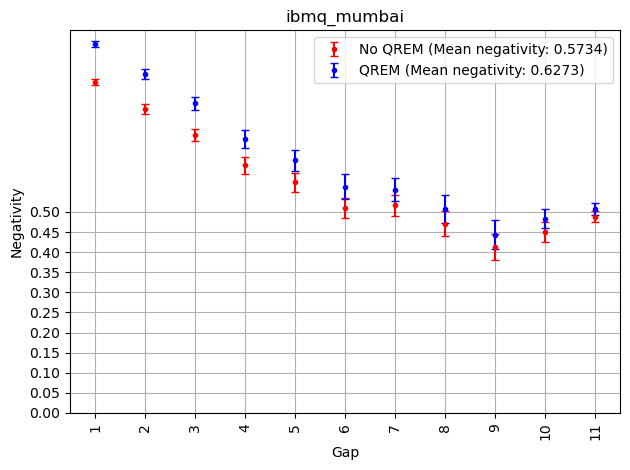

In [4]:
n_list = calc_teleported_negativities(rho_dict_list, post_processing = True, mode='mean', teleportation='swap', 
                                      witness = 'fidelity')
nmit_list = calc_teleported_negativities(rho_dict_list_mit, post_processing = True, mode='mean', teleportation='swap',
                                         witness = 'fidelity')
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate=None)
fig.tight_layout()

print(teleported_negativities_multi_gap_data(n_list, nmit_list, bellstate=None))

In [ ]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
rho_dict_list1 = test.recon_teleported_density_mats(result1, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit1 = test.recon_teleported_density_mats(result1, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 1 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
rho_dict_list2 = test.recon_teleported_density_mats(result2, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit2 = test.recon_teleported_density_mats(result2, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 2 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
rho_dict_list3 = test.recon_teleported_density_mats(result3, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit3 = test.recon_teleported_density_mats(result3, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 3 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
rho_dict_list4 = test.recon_teleported_density_mats(result4, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit4 = test.recon_teleported_density_mats(result4, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 4 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
rho_dict_list5 = test.recon_teleported_density_mats(result5, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit5 = test.recon_teleported_density_mats(result5, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 5 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
rho_dict_list6 = test.recon_teleported_density_mats(result6, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit6 = test.recon_teleported_density_mats(result6, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 6 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
rho_dict_list7 = test.recon_teleported_density_mats(result7, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit7 = test.recon_teleported_density_mats(result7, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 7 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
rho_dict_list8 = test.recon_teleported_density_mats(result8, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit8 = test.recon_teleported_density_mats(result8, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 8 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
rho_dict_list9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 9 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
rho_dict_list10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 10 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
rho_dict_list11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 11 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
rho_dict_list12 = test.recon_teleported_density_mats(result12, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit12 = test.recon_teleported_density_mats(result12, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 12 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
rho_dict_list13 = test.recon_teleported_density_mats(result13, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit13 = test.recon_teleported_density_mats(result13, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 13 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_swap_BellState_circuit()
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
rho_dict_list14 = test.recon_teleported_density_mats(result14, result_qrem, post_processing=True, apply_mit=False, teleportation='swap')
rho_dict_list_mit14 = test.recon_teleported_density_mats(result14, result_qrem, post_processing=True, apply_mit='QREM', teleportation='swap')
print('gap 14 done')

In [ ]:
n_list1 = calc_teleported_negativities(rho_dict_list1, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list2 = calc_teleported_negativities(rho_dict_list2, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list3 = calc_teleported_negativities(rho_dict_list3, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list4 = calc_teleported_negativities(rho_dict_list4, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list5 = calc_teleported_negativities(rho_dict_list5, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list6 = calc_teleported_negativities(rho_dict_list6, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list7 = calc_teleported_negativities(rho_dict_list7, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list8 = calc_teleported_negativities(rho_dict_list8, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list9 = calc_teleported_negativities(rho_dict_list9, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list10 = calc_teleported_negativities(rho_dict_list10, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list11 = calc_teleported_negativities(rho_dict_list11, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list12 = calc_teleported_negativities(rho_dict_list12, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list13 = calc_teleported_negativities(rho_dict_list13, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
n_list14 = calc_teleported_negativities(rho_dict_list14, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
#n_list15 = calc_teleported_negativities(rho_dict_list15, post_processing = True, mode='all')

nmit_list1 = calc_teleported_negativities(rho_dict_list_mit1, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list2 = calc_teleported_negativities(rho_dict_list_mit2, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list3 = calc_teleported_negativities(rho_dict_list_mit3, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list4 = calc_teleported_negativities(rho_dict_list_mit4, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list5 = calc_teleported_negativities(rho_dict_list_mit5, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list6 = calc_teleported_negativities(rho_dict_list_mit6, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list7 = calc_teleported_negativities(rho_dict_list_mit7, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list8 = calc_teleported_negativities(rho_dict_list_mit8, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list9 = calc_teleported_negativities(rho_dict_list_mit9, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list10 = calc_teleported_negativities(rho_dict_list_mit10, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list11 = calc_teleported_negativities(rho_dict_list_mit11, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list12 = calc_teleported_negativities(rho_dict_list_mit12, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list13 = calc_teleported_negativities(rho_dict_list_mit13, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
nmit_list14 = calc_teleported_negativities(rho_dict_list_mit14, post_processing = True, mode='mean', teleportation='swap', witness = 'negativity')
#nmit_list15 = calc_teleported_negativities(rho_dict_list_mit15, post_processing = True, mode='all')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i]|n_list8[i]|n_list9[i]|n_list10[i]|
                  n_list11[i]|n_list12[i]|n_list13[i]|n_list14[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i]|nmit_list8[i]|nmit_list9[i]|nmit_list10[i]|
                     nmit_list11[i]|nmit_list12[i]|nmit_list13[i]|nmit_list14[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'ignore')
fig.tight_layout()

Post-Processing Analysis

In [3]:
#max gap = 11
test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])

#post-processed for max gap = 14
#test = Teleportation(backend, 
#                     qubits_to_connect=[0,1,4,7,10,12,14,15,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)

#bs_circuits = {gap:{} for gap in range(1,15)}
#for gap, pairs_dict in test.teleported_BellState_circuits.items():
#    items = take(5, pairs_dict.items())
#    for pair, circ in items:
#        bs_circuits[gap][pair] = circ
#test.teleported_BellState_circuits = bs_circuits
test.gen_teleported_qst_circuits()

#mit = load_cal(backend=backend)
#print('M3 data obtained')
rho_dict_list1 = test.recon_teleported_density_mats(result1, result_qrem1, post_processing=True, 
                                                    apply_mit=False)
print('done')
rho_dict_list_mit1 = test.recon_teleported_density_mats(result1, result_qrem1, post_processing=True, 
                                                        apply_mit='QREM',
                                                        mitigate_qubits=[0,1,4,7,10,12,15,18,21,22,23,24,25],
                                                        mit=None)
print('done')
rho_dict_list2 = test.recon_teleported_density_mats(result2, result_qrem2, post_processing=True, 
                                                    apply_mit=False)
print('done')
rho_dict_list_mit2 = test.recon_teleported_density_mats(result2, result_qrem2, post_processing=True, 
                                                        apply_mit='QREM',
                                                        mitigate_qubits=[0,1,4,7,10,12,15,18,21,22,23,24,25])
print('done')
#print(rho_dict_list2[0][1]
print(test.reps)
rho_dict_list = rho_dict_list1 + rho_dict_list2
rho_dict_list_mit = rho_dict_list_mit1 + rho_dict_list_mit2
#rho_dict_list = rho_dict_list2
#rho_dict_list_mit = rho_dict_list_mit2
print(len(rho_dict_list))

Categorisation done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
done
QREM done
Categorisation done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
done
Categorisation done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
done
QREM done
Categorisation done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
1 done
2 done
3 done
4 done
5 done
6 done
7 done
8 done
9 done
10 done
11 done
done
2
4


[{1: {(0, 4): {'BS_1': 0.468355368814312, 'BS_2': 0.4830293917852953, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.47044388263789083, 'BS_2': 0.4673518540214561, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.4628771788501645, 'BS_2': 0.46625801372556236, 'BS_3': 0.0, 'BS_4': 0.0}, (7, 12): {'BS_1': 0.4661883904810663, 'BS_2': 0.46965761946763257, 'BS_3': 0.0, 'BS_4': 0.0}, (10, 15): {'BS_1': 0.4714460633797347, 'BS_2': 0.464453422187941, 'BS_3': 0.0, 'BS_4': 0.0}, (12, 18): {'BS_1': 0.4806229337994041, 'BS_2': 0.47651998313178734, 'BS_3': 0.0, 'BS_4': 0.0}, (15, 21): {'BS_1': 0.4920761308474916, 'BS_2': 0.4813864062862257, 'BS_3': 0.0, 'BS_4': 0.0}, (18, 23): {'BS_1': 0.4923834647807903, 'BS_2': 0.48630753378632213, 'BS_3': 0.0, 'BS_4': 0.0}, (21, 24): {'BS_1': 0.4772292726634249, 'BS_2': 0.47100049395029014, 'BS_3': 0.0, 'BS_4': 0.0}, (22, 24): {'BS_1': 0.4701792849877506, 'BS_2': 0.4695903260961815, 'BS_3': 0.0, 'BS_4': 0.0}, (23, 25): {'BS_1': 0.47156528056353614, 'BS_2': 0.395135

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
       dtype='<U2'),
 array([0.31446364, 0.26824081, 0.23136477, 0.19082967, 0.17080585,
        0.13148148, 0.11063368, 0.07793904, 0.04895555, 0.02523404,
        0.01634013]),
 array([0.00462499, 0.00632406, 0.00647683, 0.00600167, 0.00674357,
        0.00521958, 0.00525919, 0.0070773 , 0.00632972, 0.00517541,
        0.00513481]),
 array([0.45889365, 0.44085674, 0.4333731 , 0.41912452, 0.41612433,
        0.39476294, 0.37708196, 0.33459905, 0.28498478, 0.21892134,
        0.14356384]),
 array([0.00417619, 0.00525507, 0.00573334, 0.00609872, 0.00718847,
        0.00714511, 0.0084296 , 0.00965058, 0.00933272, 0.01168756,
        0.0123945 ]))

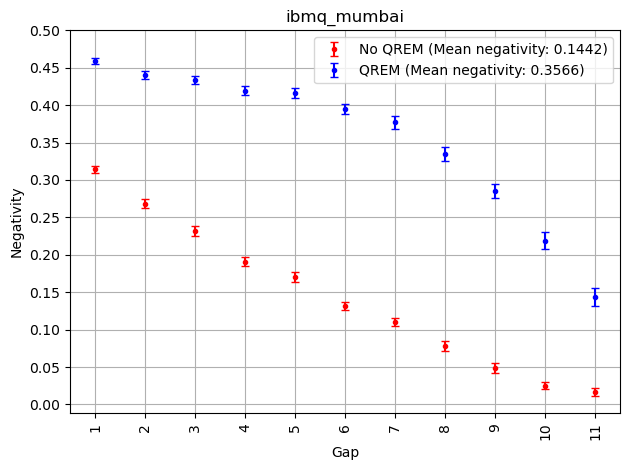

In [5]:
n_list = calc_teleported_negativities(rho_dict_list, post_processing = True, mode='all', witness='negativity')
nmit_list = calc_teleported_negativities(rho_dict_list_mit, post_processing = True, mode='all',witness='negativity')
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'ignore')
fig.tight_layout()
#print(n_list[0][3])
teleported_negativities_multi_gap_data(n_list, nmit_list, bellstate = 'ignore')

In [11]:
print(rho_dict_list[0][1])

{(0, 4): {'BS_1': array([[ 0.45209292+7.08903552e-19j,  0.01722017-5.53907811e-03j,
        -0.014955  +1.10040155e-02j,  0.37790658-2.75733788e-02j],
       [ 0.01722017+5.53907811e-03j,  0.05809888+1.44517884e-19j,
         0.05378356-6.96865526e-04j,  0.00745429-6.04689707e-03j],
       [-0.014955  -1.10040155e-02j,  0.05378356+6.96865526e-04j,
         0.0871738 +1.38910004e-18j,  0.01194186-1.47178221e-02j],
       [ 0.37790658+2.75733788e-02j,  0.00745429+6.04689707e-03j,
         0.01194186+1.47178221e-02j,  0.4026344 +3.59563741e-19j]]), 'BS_2': array([[ 0.08133948-1.66602632e-18j,  0.00913119-9.89400353e-03j,
        -0.00544491-7.65727920e-03j,  0.03852641-4.70537676e-03j],
       [ 0.00913119+9.89400353e-03j,  0.42527418+5.49779491e-17j,
         0.38517654-2.31691877e-02j,  0.01505824+1.64241508e-02j],
       [-0.00544491+7.65727920e-03j,  0.38517654+2.31691877e-02j,
         0.44074134+5.71186958e-17j,  0.02727234-1.25629376e-03j],
       [ 0.03852641+4.70537676e-03j,  0.0

In [11]:
print(nmit_list)
with open('post_process_data.pkl', 'wb') as outp:
    pickle.dump(n_list, outp, pickle.HIGHEST_PROTOCOL)
with open('post_process_data_mit.pkl', 'wb') as outp:
    pickle.dump(nmit_list, outp, pickle.HIGHEST_PROTOCOL)

[{1: {(0, 4): {'BS_1': 0.45129313490091616, 'BS_2': 0.4996000644620967, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.49349874061212995, 'BS_2': 0.4971556699789179, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.4634787760254314, 'BS_2': 0.46600705483157606, 'BS_3': 0.0, 'BS_4': 0.0}, (7, 12): {'BS_1': 0.4665706071588524, 'BS_2': 0.47020650229323097, 'BS_3': 0.0, 'BS_4': 0.0}, (10, 15): {'BS_1': 0.47128353483558216, 'BS_2': 0.4648138192532981, 'BS_3': 0.0, 'BS_4': 0.0}, (12, 18): {'BS_1': 0.48652223473965367, 'BS_2': 0.47833086116458867, 'BS_3': 0.0, 'BS_4': 0.0}, (15, 21): {'BS_1': 0.4987543750628471, 'BS_2': 0.47254383252432913, 'BS_3': 0.0, 'BS_4': 0.0}, (18, 23): {'BS_1': 0.49943843329119675, 'BS_2': 0.49343860654573385, 'BS_3': 0.0, 'BS_4': 0.0}, (21, 24): {'BS_1': 0.4944606679536533, 'BS_2': 0.4930329143562992, 'BS_3': 0.0, 'BS_4': 0.0}, (22, 24): {'BS_1': 0.49632857705215216, 'BS_2': 0.49465461158301527, 'BS_3': 0.0, 'BS_4': 0.0}, (23, 25): {'BS_1': 0.49955844186941784, 'BS_2': 

In [ ]:
test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
rho_dict_list9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit=False)
print('done')
rho_dict_list_mit9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit=True)
print(rho_dict_list9[0][9])
print(test.reps)

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
rho_dict_list10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit=False)
print('done')
rho_dict_list_mit10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit=True)
print(rho_dict_list10[0][10])
print(test.reps)

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
rho_dict_list11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit=False)
print('done')
rho_dict_list_mit11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit=True)
print(rho_dict_list11[0][11])
print(test.reps)

{(0, 4): {'BS_1': 0.27510499389503607, 'BS_2': 0.28808790834992387, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.2605037941030754, 'BS_2': 0.30418637175500896, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.36028895123117805, 'BS_2': 0.37294389722778126, 'BS_3': 0.0, 'BS_4': 0.0}, (7, 12): {'BS_1': 0.3593767673083387, 'BS_2': 0.3741593276178079, 'BS_3': 0.0, 'BS_4': 0.0}, (10, 15): {'BS_1': 0.1794633797505282, 'BS_2': 0.2086726577811535, 'BS_3': 0.0, 'BS_4': 0.0}, (12, 18): {'BS_1': 0.1282378797065405, 'BS_2': 0.2768051635336245, 'BS_3': 0.0, 'BS_4': 0.0}, (15, 21): {'BS_1': 0.18794315280812127, 'BS_2': 0.17604547587632732, 'BS_3': 0.0, 'BS_4': 0.0}, (18, 23): {'BS_1': 0.28210654840912025, 'BS_2': 0.31025143974445124, 'BS_3': 0.0, 'BS_4': 0.0}}
{(0, 4): {'BS_1': 0.4122699735620489, 'BS_2': 0.4709280973984281, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.4254209718145602, 'BS_2': 0.4137388795483602, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.4740253675253689, 'BS_2': 0.47291189703

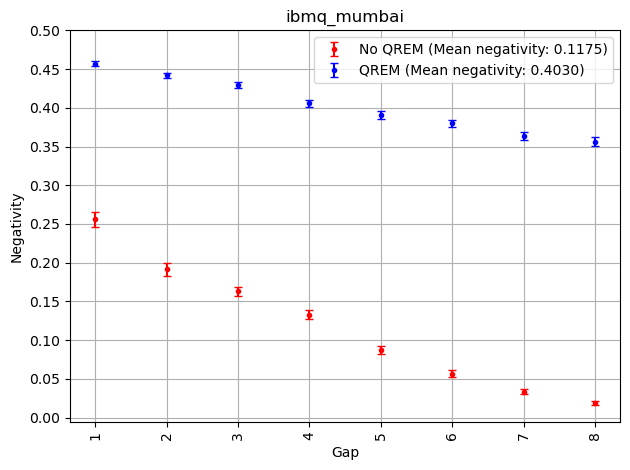

In [27]:
n_list = calc_teleported_negativities(rho_dict_list, post_processing = True, mode='all')
nmit_list = calc_teleported_negativities(rho_dict_list_mit, post_processing = True, mode='all')

print(n_list[0][1])
print(nmit_list[0][1])
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'BS_1')
fig.tight_layout()

Post-Selection 14q ibm_torino Analysis

In [ ]:
with open('optimal paths/CX_err_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_CXerr = pickle.load(file)
with open('optimal paths/negativity_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_n = pickle.load(file)
with open('optimal paths/negativity_mitigated_optimal_paths_2023_12_21.pkl', 'rb') as file:
    best_paths_nmit = pickle.load(file)
print(best_paths_nmit)

for gap in range(1,15):
    test = Teleportation(backend, qubits_to_connect=best_paths_nmit[gap][1])
    test.gen_teleportation_basis()
    test.gen_teleported_BellState_circuit(post_processing = True)
    test.gen_teleported_qst_circuits()
    print(test.name_list)
    
    exec(f'{result}=result{gap}')
    rho_dict_list = test.recon_teleported_density_mats(result, result_qrem, post_processing=True, apply_mit=False)
    rho_dict_list_mit = test.recon_teleported_density_mats(result, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                            mitigate_qubits=best_paths_nmit[gap][1])
    
    exec(f'n_list{gap} = {calc_teleported_negativities(rho_dict_list, post_processing = True, mode='all', witness='negativity')}')
    exec(f'nmit_list{gap} = {calc_teleported_negativities(rho_dict_list_mit, post_processing = True, mode='all', witness='negativity')}')
    #exec(f'n_list{gap}={n_list}')
    #exec(f'nmit_list{gap}={nmit_list}')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i]|n_list8[i]|n_list9[i]|n_list10[i]|
                  n_list11[i]|n_list12[i]|n_list13[i]|n_list14[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i]|nmit_list8[i]|nmit_list9[i]|nmit_list10[i]|
                     nmit_list11[i]|nmit_list12[i]|nmit_list13[i]|nmit_list14[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'ignore')
fig.tight_layout()
teleported_negativities_multi_gap_data(n_list, nmit_list, bellstate = 'ignore')

In [3]:
#2,3,4,7,10,11,12,13,14,16,18,19,20,21,22,24,25 to mitigate (error>0.01)
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
rho_dict_list1 = test.recon_teleported_density_mats(result1, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit1 = test.recon_teleported_density_mats(result1, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19])
print('gap 1 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
rho_dict_list2 = test.recon_teleported_density_mats(result2, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit2 = test.recon_teleported_density_mats(result2, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19,22])
print('gap 2 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
rho_dict_list3 = test.recon_teleported_density_mats(result3, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit3 = test.recon_teleported_density_mats(result3, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19,22,25])
print('gap 3 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
rho_dict_list4 = test.recon_teleported_density_mats(result4, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit4 = test.recon_teleported_density_mats(result4, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19,22,24,25])
print('gap 4 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
rho_dict_list5 = test.recon_teleported_density_mats(result5, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit5 = test.recon_teleported_density_mats(result5, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19,22,24,25])
print('gap 5 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
rho_dict_list6 = test.recon_teleported_density_mats(result6, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit6 = test.recon_teleported_density_mats(result6, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,19,21,22,24,25])
print('gap 6 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
rho_dict_list7 = test.recon_teleported_density_mats(result7, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit7 = test.recon_teleported_density_mats(result7, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 7 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
rho_dict_list8 = test.recon_teleported_density_mats(result8, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit8 = test.recon_teleported_density_mats(result8, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 8 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
rho_dict_list9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit9 = test.recon_teleported_density_mats(result9, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 9 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
rho_dict_list10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit10 = test.recon_teleported_density_mats(result10, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 10 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
rho_dict_list11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit11 = test.recon_teleported_density_mats(result11, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 11 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {12:test.teleported_BellState_circuits[12]}
test.gen_teleported_qst_circuits()
rho_dict_list12 = test.recon_teleported_density_mats(result12, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit12 = test.recon_teleported_density_mats(result12, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 12 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {13:test.teleported_BellState_circuits[13]}
test.gen_teleported_qst_circuits()
rho_dict_list13 = test.recon_teleported_density_mats(result13, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit13 = test.recon_teleported_density_mats(result13, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 13 done')

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,13,14,16,18,19,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = True)
test.teleported_BellState_circuits = {14:test.teleported_BellState_circuits[14]}
test.gen_teleported_qst_circuits()
rho_dict_list14 = test.recon_teleported_density_mats(result14, result_qrem, post_processing=True, apply_mit=False)
rho_dict_list_mit14 = test.recon_teleported_density_mats(result14, result_qrem, post_processing=True, apply_mit='reduced_QREM',
                                                        mitigate_qubits=[4,7,10,12,13,14,16,18,19,21,22,24,25])
print('gap 14 done')

Categorisation done
1 done
1 done
1 done
1 done
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
reduced_QREM done
Categorisation done
1 done
1 done
1 done
1 done
gap 1 done
Categorisation done
2 done
2 done
2 done
2 done
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16
16

[{1: {(0, 4): {'BS_1': 0.436970913948059, 'BS_2': 0.43583620069200135, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.43255605464806596, 'BS_2': 0.429367094875936, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.3630187621086349, 'BS_2': 0.36933704982374704, 'BS_3': 0.0, 'BS_4': 0.0}, (7, 12): {'BS_1': 0.3385481372676257, 'BS_2': 0.40994142079516227, 'BS_3': 0.0, 'BS_4': 0.0}, (10, 13): {'BS_1': 0.22563876110977454, 'BS_2': 0.23002846859427314, 'BS_3': 0.0, 'BS_4': 0.0}, (12, 14): {'BS_1': 0.3706570588116781, 'BS_2': 0.40780593510773466, 'BS_3': 0.0, 'BS_4': 0.0}, (13, 16): {'BS_1': 0.21349051365008498, 'BS_2': 0.23995236017239857, 'BS_3': 0.0, 'BS_4': 0.0}, (14, 19): {'BS_1': 0.3134009206756567, 'BS_2': 0.288954264762905, 'BS_3': 0.0, 'BS_4': 0.0}}, 2: {(0, 7): {'BS_1': 0.4207287702006663, 'BS_2': 0.41893114781281865, 'BS_3': 0.42547603395017153, 'BS_4': 0.41938413268213215}, (1, 10): {'BS_1': 0.33244091779935164, 'BS_2': 0.3192032548803939, 'BS_3': 0.33046427433104286, 'BS_4': 0.316901

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
        '13', '14'], dtype='<U2'),
 array([0.34391086, 0.29599072, 0.22912092, 0.22188517, 0.17675381,
        0.14290014, 0.10294012, 0.04786488, 0.05353358, 0.01639778,
        0.04382208, 0.00421234, 0.01425442, 0.        ]),
 array([0.01353871, 0.01260543, 0.01264191, 0.00957597, 0.00959081,
        0.00660103, 0.00770114, 0.00450763, 0.0066139 , 0.0032224 ,
        0.00684121, 0.00159442, 0.00510996, 0.        ]),
 array([0.39296357, 0.34445648, 0.29576939, 0.28519633, 0.25225024,
        0.20946728, 0.17602174, 0.10048851, 0.11040878, 0.04849139,
        0.07049163, 0.01144668, 0.01930675, 0.        ]),
 array([0.00995515, 0.0114502 , 0.01236769, 0.00880695, 0.00957845,
        0.006814  , 0.01001606, 0.00863806, 0.01141559, 0.00645284,
        0.01073977, 0.00324746, 0.00688393, 0.        ]))

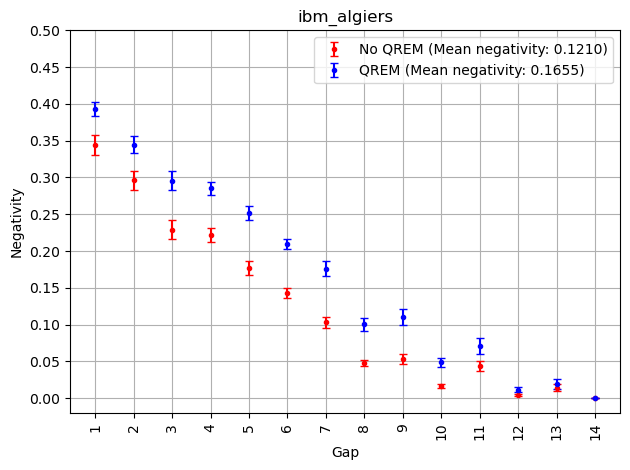

In [5]:
n_list1 = calc_teleported_negativities(rho_dict_list1, post_processing = True, mode='all', witness='negativity')
n_list2 = calc_teleported_negativities(rho_dict_list2, post_processing = True, mode='all', witness='negativity')
n_list3 = calc_teleported_negativities(rho_dict_list3, post_processing = True, mode='all', witness='negativity')
n_list4 = calc_teleported_negativities(rho_dict_list4, post_processing = True, mode='all', witness='negativity')
n_list5 = calc_teleported_negativities(rho_dict_list5, post_processing = True, mode='all', witness='negativity')
n_list6 = calc_teleported_negativities(rho_dict_list6, post_processing = True, mode='all', witness='negativity')
n_list7 = calc_teleported_negativities(rho_dict_list7, post_processing = True, mode='all', witness='negativity')
n_list8 = calc_teleported_negativities(rho_dict_list8, post_processing = True, mode='all', witness='negativity')
n_list9 = calc_teleported_negativities(rho_dict_list9, post_processing = True, mode='all', witness='negativity')
n_list10 = calc_teleported_negativities(rho_dict_list10, post_processing = True, mode='all', witness='negativity')
n_list11 = calc_teleported_negativities(rho_dict_list11, post_processing = True, mode='all', witness='negativity')
n_list12 = calc_teleported_negativities(rho_dict_list12, post_processing = True, mode='all', witness='negativity')
n_list13 = calc_teleported_negativities(rho_dict_list13, post_processing = True, mode='all', witness='negativity')
n_list14 = calc_teleported_negativities(rho_dict_list14, post_processing = True, mode='all', witness='negativity')
#n_list15 = calc_teleported_negativities(rho_dict_list15, post_processing = True, mode='all')

nmit_list1 = calc_teleported_negativities(rho_dict_list_mit1, post_processing = True, mode='all', witness='negativity')
nmit_list2 = calc_teleported_negativities(rho_dict_list_mit2, post_processing = True, mode='all', witness='negativity')
nmit_list3 = calc_teleported_negativities(rho_dict_list_mit3, post_processing = True, mode='all', witness='negativity')
nmit_list4 = calc_teleported_negativities(rho_dict_list_mit4, post_processing = True, mode='all', witness='negativity')
nmit_list5 = calc_teleported_negativities(rho_dict_list_mit5, post_processing = True, mode='all', witness='negativity')
nmit_list6 = calc_teleported_negativities(rho_dict_list_mit6, post_processing = True, mode='all', witness='negativity')
nmit_list7 = calc_teleported_negativities(rho_dict_list_mit7, post_processing = True, mode='all', witness='negativity')
nmit_list8 = calc_teleported_negativities(rho_dict_list_mit8, post_processing = True, mode='all', witness='negativity')
nmit_list9 = calc_teleported_negativities(rho_dict_list_mit9, post_processing = True, mode='all', witness='negativity')
nmit_list10 = calc_teleported_negativities(rho_dict_list_mit10, post_processing = True, mode='all', witness='negativity')
nmit_list11 = calc_teleported_negativities(rho_dict_list_mit11, post_processing = True, mode='all', witness='negativity')
nmit_list12 = calc_teleported_negativities(rho_dict_list_mit12, post_processing = True, mode='all', witness='negativity')
nmit_list13 = calc_teleported_negativities(rho_dict_list_mit13, post_processing = True, mode='all', witness='negativity')
nmit_list14 = calc_teleported_negativities(rho_dict_list_mit14, post_processing = True, mode='all', witness='negativity')
#nmit_list15 = calc_teleported_negativities(rho_dict_list_mit15, post_processing = True, mode='all')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i]|n_list8[i]|n_list9[i]|n_list10[i]|
                  n_list11[i]|n_list12[i]|n_list13[i]|n_list14[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i]|nmit_list8[i]|nmit_list9[i]|nmit_list10[i]|
                     nmit_list11[i]|nmit_list12[i]|nmit_list13[i]|nmit_list14[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'ignore')
fig.tight_layout()
teleported_negativities_multi_gap_data(n_list, nmit_list, bellstate = 'ignore')


{(0, 4): {'BS_1': 0.3112922660205649, 'BS_2': 0.32833077414506157, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.31877320183070135, 'BS_2': 0.3340604546063612, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.3789624629869176, 'BS_2': 0.393526905325051, 'BS_3': 0.0, 'BS_4': 0.0}, (7, 12): {'BS_1': 0.11690059802043265, 'BS_2': 0.13803231199192792, 'BS_3': 0.0, 'BS_4': 0.0}, (10, 15): {'BS_1': 0.329086119710974, 'BS_2': 0.049435137680156796, 'BS_3': 0.0, 'BS_4': 0.0}, (12, 18): {'BS_1': 0.17414457962034693, 'BS_2': 0.1715570343542392, 'BS_3': 0.0, 'BS_4': 0.0}, (15, 21): {'BS_1': 0.34066597345443805, 'BS_2': 0.29213185803680164, 'BS_3': 0.0, 'BS_4': 0.0}, (18, 23): {'BS_1': 0.26674080950787604, 'BS_2': 0.3160809013103145, 'BS_3': 0.0, 'BS_4': 0.0}}
{(0, 4): {'BS_1': 0.43693319747736, 'BS_2': 0.4991490088214171, 'BS_3': 0.0, 'BS_4': 0.0}, (1, 7): {'BS_1': 0.4985554947379689, 'BS_2': 0.4758165842014557, 'BS_3': 0.0, 'BS_4': 0.0}, (4, 10): {'BS_1': 0.4764481563841326, 'BS_2': 0.46737586570115

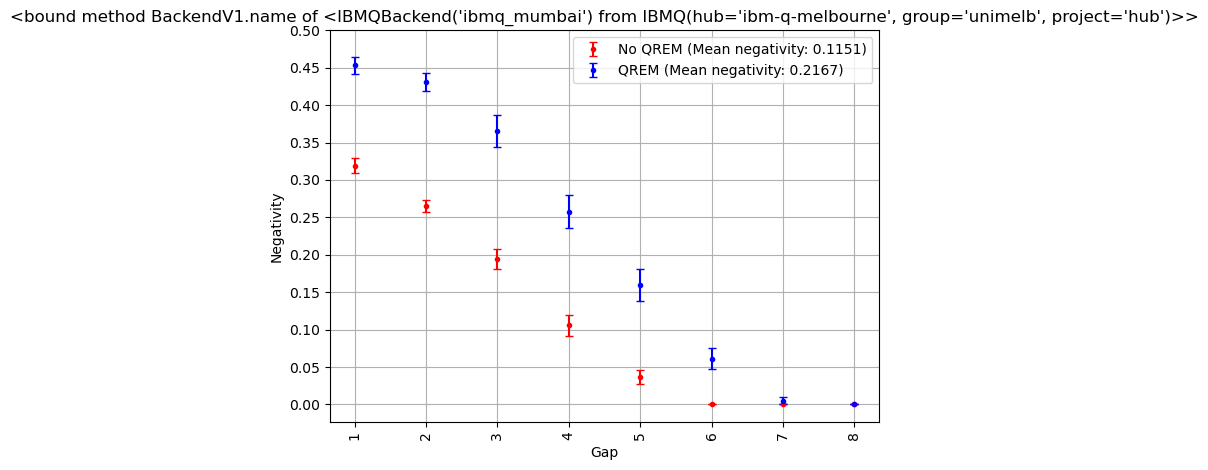

In [4]:
n_list = calc_teleported_negativities(rho_dict_list, post_processing = True, mode='all')
nmit_list = calc_teleported_negativities(rho_dict_list_mit, post_processing = True, mode='all')
print(n_list[0][1])
print(nmit_list[0][1])
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = 'BS_1')
fig.tight_layout()

Dynamic Circuits Analysis

In [3]:
test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
rho_dict_list1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list1 = rho_dict_list1_1
rho_dict_list_mit1 = rho_dict_list_mit1_1
print(test.reps)
print(rho_dict_list1[0][1])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
rho_dict_list2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list2 = rho_dict_list2_1
rho_dict_list_mit2 = rho_dict_list_mit2_1
print(rho_dict_list2[0][2])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
rho_dict_list3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list3 = rho_dict_list3_1
rho_dict_list_mit3 = rho_dict_list_mit3_1
print(rho_dict_list3[0][3])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
rho_dict_list4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list4 = rho_dict_list4_1
rho_dict_list_mit4 = rho_dict_list_mit4_1
print(rho_dict_list4[0][4])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
rho_dict_list5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list5 = rho_dict_list5_1
rho_dict_list_mit5 = rho_dict_list_mit5_1
print(rho_dict_list5[0][5])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
rho_dict_list6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list6 = rho_dict_list6_1
rho_dict_list_mit6 = rho_dict_list_mit6_1
print(rho_dict_list6[0][6])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
rho_dict_list7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list7 = rho_dict_list7_1
rho_dict_list_mit7 = rho_dict_list_mit7_1
print(rho_dict_list7[0][7])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
rho_dict_list8_1 = test.recon_teleported_density_mats(result8_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit8_1 = test.recon_teleported_density_mats(result8_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list8 = rho_dict_list8_1
rho_dict_list_mit8 = rho_dict_list_mit8_1
print(rho_dict_list8[0][8])

test = Teleportation(backend, 
                     qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
rho_dict_list9_1 = test.recon_teleported_density_mats(result9_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit9_1 = test.recon_teleported_density_mats(result9_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list9 = rho_dict_list9_1
rho_dict_list_mit9 = rho_dict_list_mit9_1
print(rho_dict_list9[0][9])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
rho_dict_list10_1 = test.recon_teleported_density_mats(result10_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit10_1 = test.recon_teleported_density_mats(result10_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list10 = rho_dict_list10_1
rho_dict_list_mit10 = rho_dict_list_mit10_1
print(rho_dict_list10[0][10])

test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
rho_dict_list11_1 = test.recon_teleported_density_mats(result11_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list_mit11_1 = test.recon_teleported_density_mats(result11_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list11 = rho_dict_list11_1
rho_dict_list_mit11 = rho_dict_list_mit11_1
print(rho_dict_list11[0][11])

4
{(0, 4): array([[ 0.26798503+3.08040576e-18j,  0.20302327-9.33837891e-03j,
         0.03210449+4.25211589e-03j, -0.01757812+5.79833984e-03j],
       [ 0.20302327+9.33837891e-03j,  0.25118001+2.73963191e-18j,
         0.02685547+2.16674805e-02j, -0.01379395-7.95491536e-03j],
       [ 0.03210449-4.25211589e-03j,  0.02685547-2.16674805e-02j,
         0.24833171+2.64256159e-18j, -0.18308512-1.00708008e-02j],
       [-0.01757812-5.79833984e-03j, -0.01379395+7.95491536e-03j,
        -0.18308512+1.00708008e-02j,  0.23250326+1.94574159e-18j]]), (1, 7): array([[ 0.25807699+1.74840404e-18j,  0.21067301-5.41178385e-03j,
         0.14542643+6.46972656e-02j, -0.11590576-5.85327148e-02j],
       [ 0.21067301+5.41178385e-03j,  0.27492269+1.39995710e-18j,
         0.13824463+8.66088867e-02j, -0.11446126-8.76464844e-02j],
       [ 0.14542643-6.46972656e-02j,  0.13824463-8.66088867e-02j,
         0.25303141+1.48998350e-18j, -0.19875081+1.05794271e-03j],
       [-0.11590576+5.85327148e-02j, -0.11446126

[{1: {(0, 4): 0.4882202148437499, (1, 7): 0.7117309570312507, (4, 10): 0.6973266601562499, (7, 12): 0.5498657226562497, (10, 15): 0.726806640625, (12, 18): 0.573120117187499, (15, 21): 0.6077880859374999, (18, 23): 0.6854248046875007}, 2: {(0, 7): 0.6710205078124998, (1, 10): 0.6770019531250001, (4, 12): 0.5260009765624994, (7, 15): 0.69219970703125, (10, 18): 0.58990478515625, (12, 21): 0.5682373046875001, (15, 23): 0.6049194335937503}, 3: {(0, 10): 0.6501464843749996, (1, 12): 0.5363769531249994, (4, 15): 0.6636352539062501, (7, 18): 0.5974121093750004, (10, 21): 0.5985717773437493, (12, 23): 0.6620483398437509}, 4: {(0, 12): 0.5128173828124993, (1, 15): 0.6530151367187512, (4, 18): 0.48840332031249983, (7, 21): 0.5823364257812504, (10, 23): 0.6065063476562504}, 5: {(0, 15): 0.6278076171875, (1, 18): 0.5281982421875003, (4, 21): 0.55352783203125, (7, 23): 0.5995483398437492}, 6: {(0, 18): 0.5264892578125001, (1, 21): 0.5142822265625002, (4, 23): 0.549072265625}, 7: {(0, 21): 0.518127

(array(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11'],
       dtype='<U2'),
 array([0.63022232, 0.61808995, 0.61888631, 0.57052917, 0.5763588 ,
        0.53373718, 0.53321075, 0.53164673, 0.41076152, 0.39710999,
        0.38996887]),
 array([0.01489219, 0.01056533, 0.00874903, 0.01327966, 0.01007344,
        0.00599637, 0.00614234, 0.0033478 , 0.00929563, 0.00528978,
        0.00160462]),
 array([0.71486116, 0.69251584, 0.70439442, 0.65083594, 0.64746986,
        0.61177672, 0.61145379, 0.56942761, 0.44382594, 0.4275559 ,
        0.39652668]),
 array([0.02097441, 0.0140588 , 0.00573335, 0.02133623, 0.0107956 ,
        0.00242874, 0.02314585, 0.00383341, 0.01021466, 0.01265455,
        0.00162217]))

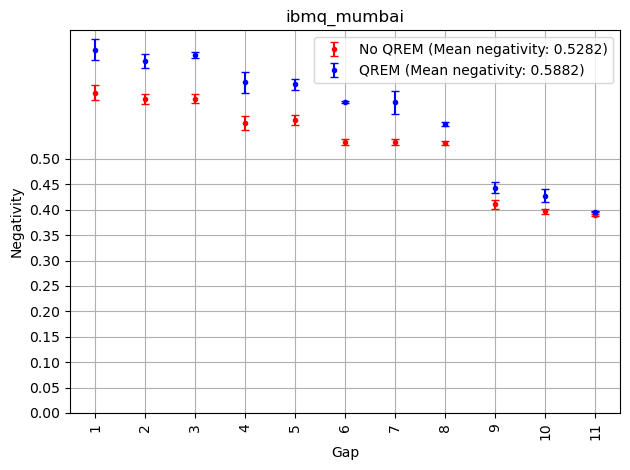

In [4]:
n_list1 = calc_teleported_negativities(rho_dict_list1, post_processing = False, mode='mean', witness='fidelity')
n_list2 = calc_teleported_negativities(rho_dict_list2, post_processing = False, mode='mean', witness='fidelity')
n_list3 = calc_teleported_negativities(rho_dict_list3, post_processing = False, mode='mean', witness='fidelity')
n_list4 = calc_teleported_negativities(rho_dict_list4, post_processing = False, mode='mean', witness='fidelity')
n_list5 = calc_teleported_negativities(rho_dict_list5, post_processing = False, mode='mean', witness='fidelity')
n_list6 = calc_teleported_negativities(rho_dict_list6, post_processing = False, mode='mean', witness='fidelity')
n_list7 = calc_teleported_negativities(rho_dict_list7, post_processing = False, mode='mean', witness='fidelity')
n_list8 = calc_teleported_negativities(rho_dict_list8, post_processing = False, mode='mean', witness='fidelity')
n_list9 = calc_teleported_negativities(rho_dict_list9, post_processing = False, mode='mean', witness='fidelity')
n_list10 = calc_teleported_negativities(rho_dict_list10, post_processing = False, mode='mean', witness='fidelity')
n_list11 = calc_teleported_negativities(rho_dict_list11, post_processing = False, mode='mean', witness='fidelity')
nmit_list1 = calc_teleported_negativities(rho_dict_list_mit1, post_processing = False, mode='mean', witness='fidelity')
nmit_list2 = calc_teleported_negativities(rho_dict_list_mit2, post_processing = False, mode='mean', witness='fidelity')
nmit_list3 = calc_teleported_negativities(rho_dict_list_mit3, post_processing = False, mode='mean', witness='fidelity')
nmit_list4 = calc_teleported_negativities(rho_dict_list_mit4, post_processing = False, mode='mean', witness='fidelity')
nmit_list5 = calc_teleported_negativities(rho_dict_list_mit5, post_processing = False, mode='mean', witness='fidelity')
nmit_list6 = calc_teleported_negativities(rho_dict_list_mit6, post_processing = False, mode='mean', witness='fidelity')
nmit_list7 = calc_teleported_negativities(rho_dict_list_mit7, post_processing = False, mode='mean', witness='fidelity')
nmit_list8 = calc_teleported_negativities(rho_dict_list_mit8, post_processing = False, mode='mean', witness='fidelity')
nmit_list9 = calc_teleported_negativities(rho_dict_list_mit9, post_processing = False, mode='mean', witness='fidelity')
nmit_list10 = calc_teleported_negativities(rho_dict_list_mit10, post_processing = False, mode='mean', witness='fidelity')
nmit_list11 = calc_teleported_negativities(rho_dict_list_mit11, post_processing = False, mode='mean', witness='fidelity')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i]|n_list8[i]|
                  n_list9[i]|n_list10[i]|n_list11[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i]|nmit_list8[i]|
                     nmit_list9[i]|nmit_list10[i]|nmit_list11[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = None)
fig.tight_layout()

teleported_negativities_multi_gap_data(n_list, nmit_list, bellstate = None)

In [6]:
test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
rho_dict_list1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list1_2 = test.recon_teleported_density_mats(result1_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit1_2 = test.recon_teleported_density_mats(result1_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list1 = rho_dict_list1_1# + rho_dict_list1_2
rho_dict_list_mit1 = rho_dict_list_mit1_1# + rho_dict_list_mit1_2
print(rho_dict_list1[0][1])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
rho_dict_list2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list2_2 = test.recon_teleported_density_mats(result2_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit2_2 = test.recon_teleported_density_mats(result2_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list2 = rho_dict_list2_1# + rho_dict_list2_2
rho_dict_list_mit2 = rho_dict_list_mit2_1# + rho_dict_list_mit2_2
print(rho_dict_list2[0][2])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
rho_dict_list3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list3_2 = test.recon_teleported_density_mats(result3_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit3_2 = test.recon_teleported_density_mats(result3_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list3 = rho_dict_list3_1# + rho_dict_list3_2
rho_dict_list_mit3 = rho_dict_list_mit3_1# + rho_dict_list_mit3_2
print(rho_dict_list3[0][3])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
rho_dict_list4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list4_2 = test.recon_teleported_density_mats(result4_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit4_2 = test.recon_teleported_density_mats(result4_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list4 = rho_dict_list4_1# + rho_dict_list4_2
rho_dict_list_mit4 = rho_dict_list_mit4_1# + rho_dict_list_mit4_2
print(rho_dict_list4[0][4])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
rho_dict_list5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list5_2 = test.recon_teleported_density_mats(result5_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit5_2 = test.recon_teleported_density_mats(result5_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list5 = rho_dict_list5_1# + rho_dict_list5_2
rho_dict_list_mit5 = rho_dict_list_mit5_1# + rho_dict_list_mit5_2
print(rho_dict_list5[0][5])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
rho_dict_list6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list6_2 = test.recon_teleported_density_mats(result6_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit6_2 = test.recon_teleported_density_mats(result6_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list6 = rho_dict_list6_1# + rho_dict_list6_2
rho_dict_list_mit6 = rho_dict_list_mit6_1# + rho_dict_list_mit6_2
print(rho_dict_list6[0][6])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
rho_dict_list7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list7_2 = test.recon_teleported_density_mats(result7_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit7_2 = test.recon_teleported_density_mats(result7_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list7 = rho_dict_list7_1# + rho_dict_list7_2
rho_dict_list_mit7 = rho_dict_list_mit7_1# + rho_dict_list_mit7_2
print(rho_dict_list7[0][7])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {8:test.teleported_BellState_circuits[8]}
test.gen_teleported_qst_circuits()
rho_dict_list8_1 = test.recon_teleported_density_mats(result8_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit8_1 = test.recon_teleported_density_mats(result8_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list8 = rho_dict_list8_1# + rho_dict_list8_2
rho_dict_list_mit8 = rho_dict_list_mit8_1# + rho_dict_list_mit8_2
print(rho_dict_list8[0][8])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {9:test.teleported_BellState_circuits[9]}
test.gen_teleported_qst_circuits()
rho_dict_list9_1 = test.recon_teleported_density_mats(result9_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit9_1 = test.recon_teleported_density_mats(result9_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list9 = rho_dict_list9_1# + rho_dict_list8_2
rho_dict_list_mit9 = rho_dict_list_mit9_1# + rho_dict_list_mit8_2
print(rho_dict_list9[0][9])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {10:test.teleported_BellState_circuits[10]}
test.gen_teleported_qst_circuits()
rho_dict_list10_1 = test.recon_teleported_density_mats(result10_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit10_1 = test.recon_teleported_density_mats(result10_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list10 = rho_dict_list10_1# + rho_dict_list8_2
rho_dict_list_mit10 = rho_dict_list_mit10_1# + rho_dict_list_mit8_2
print(rho_dict_list10[0][10])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21,22,23,24,25])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {11:test.teleported_BellState_circuits[11]}
test.gen_teleported_qst_circuits()
rho_dict_list11_1 = test.recon_teleported_density_mats(result11_1, result_qrem_1, post_processing=False, apply_mit=False)
#rho_dict_list8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit11_1 = test.recon_teleported_density_mats(result11_1, result_qrem_1, post_processing=False, apply_mit=True)
#rho_dict_list_mit8_2 = test.recon_teleported_density_mats(result8_2, result_qrem_2, post_processing=False, apply_mit=True)
rho_dict_list11 = rho_dict_list11_1# + rho_dict_list8_2
rho_dict_list_mit11 = rho_dict_list_mit11_1# + rho_dict_list_mit8_2
print(rho_dict_list11[0][11])

{(0, 4): array([[ 0.26798503+3.08040576e-18j,  0.20302327-9.33837891e-03j,
         0.03210449+4.25211589e-03j, -0.01757812+5.79833984e-03j],
       [ 0.20302327+9.33837891e-03j,  0.25118001+2.73963191e-18j,
         0.02685547+2.16674805e-02j, -0.01379395-7.95491536e-03j],
       [ 0.03210449-4.25211589e-03j,  0.02685547-2.16674805e-02j,
         0.24833171+2.64256159e-18j, -0.18308512-1.00708008e-02j],
       [-0.01757812-5.79833984e-03j, -0.01379395+7.95491536e-03j,
        -0.18308512+1.00708008e-02j,  0.23250326+1.94574159e-18j]]), (1, 7): array([[ 0.25807699+1.74840404e-18j,  0.21067301-5.41178385e-03j,
         0.14542643+6.46972656e-02j, -0.11590576-5.85327148e-02j],
       [ 0.21067301+5.41178385e-03j,  0.27492269+1.39995710e-18j,
         0.13824463+8.66088867e-02j, -0.11446126-8.76464844e-02j],
       [ 0.14542643-6.46972656e-02j,  0.13824463-8.66088867e-02j,
         0.25303141+1.48998350e-18j, -0.19875081+1.05794271e-03j],
       [-0.11590576+5.85327148e-02j, -0.11446126+8

[{1: {(0, 4): 0.0, (1, 7): 0.2536705368776507, (4, 10): 0.2339981027890718, (7, 12): 0.09520522257937875, (10, 15): 0.25928739177442284, (12, 18): 0.0930088330332282, (15, 21): 0.17215517342905745, (18, 23): 0.2167387545983574}, 2: {(0, 7): 0.23315616934418248, (1, 10): 0.21878269986011328, (4, 12): 0.08299124201270415, (7, 15): 0.23065588817321603, (10, 18): 0.12070180797168034, (12, 21): 0.12340228650098223, (15, 23): 0.14098579340775905}, 3: {(0, 10): 0.15119853854908738, (1, 12): 0.03940613705517141, (4, 15): 0.16703862953279286, (7, 18): 0.0990116428433265, (10, 21): 0.10465683745086574, (12, 23): 0.16514944745864085}, 4: {(0, 12): 0.01406552019122631, (1, 15): 0.15914602798346134, (4, 18): 0.0, (7, 21): 0.08662991601129111, (10, 23): 0.11389700088555207}, 5: {(0, 15): 0.1300848537515745, (1, 18): 0.03967974890963958, (4, 21): 0.05976564749116883, (7, 23): 0.1042149788298406}, 6: {(0, 18): 0.03273410752016476, (1, 21): 0.019968079699632373, (4, 23): 0.054919459349741004}, 7: {(0, 

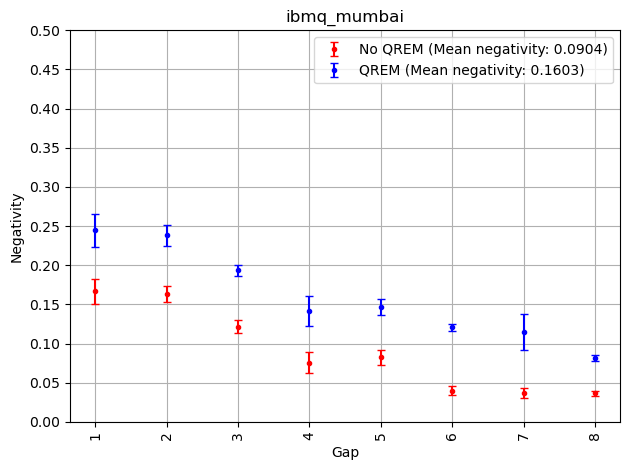

In [7]:
n_list1 = calc_teleported_negativities(rho_dict_list1, post_processing = False, mode='mean')
n_list2 = calc_teleported_negativities(rho_dict_list2, post_processing = False, mode='mean')
n_list3 = calc_teleported_negativities(rho_dict_list3, post_processing = False, mode='mean')
n_list4 = calc_teleported_negativities(rho_dict_list4, post_processing = False, mode='mean')
n_list5 = calc_teleported_negativities(rho_dict_list5, post_processing = False, mode='mean')
n_list6 = calc_teleported_negativities(rho_dict_list6, post_processing = False, mode='mean')
n_list7 = calc_teleported_negativities(rho_dict_list7, post_processing = False, mode='mean')
n_list8 = calc_teleported_negativities(rho_dict_list8, post_processing = False, mode='mean')
n_list9 = calc_teleported_negativities(rho_dict_list9, post_processing = False, mode='mean')
n_list10 = calc_teleported_negativities(rho_dict_list10, post_processing = False, mode='mean')
n_list11 = calc_teleported_negativities(rho_dict_list11, post_processing = False, mode='mean')
nmit_list1 = calc_teleported_negativities(rho_dict_list_mit1, post_processing = False, mode='mean')
nmit_list2 = calc_teleported_negativities(rho_dict_list_mit2, post_processing = False, mode='mean')
nmit_list3 = calc_teleported_negativities(rho_dict_list_mit3, post_processing = False, mode='mean')
nmit_list4 = calc_teleported_negativities(rho_dict_list_mit4, post_processing = False, mode='mean')
nmit_list5 = calc_teleported_negativities(rho_dict_list_mit5, post_processing = False, mode='mean')
nmit_list6 = calc_teleported_negativities(rho_dict_list_mit6, post_processing = False, mode='mean')
nmit_list7 = calc_teleported_negativities(rho_dict_list_mit7, post_processing = False, mode='mean')
nmit_list8 = calc_teleported_negativities(rho_dict_list_mit8, post_processing = False, mode='mean')
nmit_list9 = calc_teleported_negativities(rho_dict_list_mit9, post_processing = False, mode='mean')
nmit_list10 = calc_teleported_negativities(rho_dict_list_mit10, post_processing = False, mode='mean')
nmit_list11 = calc_teleported_negativities(rho_dict_list_mit11, post_processing = False, mode='mean')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i]|n_list8[i]|
                  n_list9[i]|n_list10[i]|n_list11[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i]|nmit_list8[i]|
                     nmit_list9[i]|nmit_list10[i]|nmit_list11[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = None)
fig.tight_layout()

Dynamic circuit on Mumbai (larger size)

In [9]:
test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {1:test.teleported_BellState_circuits[1]}
test.gen_teleported_qst_circuits()
rho_dict_list1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list1_2 = test.recon_teleported_density_mats(result1_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit1_1 = test.recon_teleported_density_mats(result1_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit1_2 = test.recon_teleported_density_mats(result1_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list1_3 = test.recon_teleported_density_mats(result1_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit1_3 = test.recon_teleported_density_mats(result1_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list1 = rho_dict_list1_1 + rho_dict_list1_2 + rho_dict_list1_3
rho_dict_list_mit1 = rho_dict_list_mit1_1 + rho_dict_list_mit1_2 + rho_dict_list_mit1_3
print(rho_dict_list1[0][1])
print(rho_dict_list_mit1[0][1])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {2:test.teleported_BellState_circuits[2]}
test.gen_teleported_qst_circuits()
rho_dict_list2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list2_2 = test.recon_teleported_density_mats(result2_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit2_1 = test.recon_teleported_density_mats(result2_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit2_2 = test.recon_teleported_density_mats(result2_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list2_3 = test.recon_teleported_density_mats(result2_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit2_3 = test.recon_teleported_density_mats(result2_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list2 = rho_dict_list2_1 + rho_dict_list2_2 + rho_dict_list2_3
rho_dict_list_mit2 = rho_dict_list_mit2_1 + rho_dict_list_mit2_2 + rho_dict_list_mit2_3
print(rho_dict_list2[0][2])
print(rho_dict_list_mit2[0][2])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {3:test.teleported_BellState_circuits[3]}
test.gen_teleported_qst_circuits()
rho_dict_list3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list3_2 = test.recon_teleported_density_mats(result3_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit3_1 = test.recon_teleported_density_mats(result3_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit3_2 = test.recon_teleported_density_mats(result3_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list3_3 = test.recon_teleported_density_mats(result3_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit3_3 = test.recon_teleported_density_mats(result3_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list3 = rho_dict_list3_1 + rho_dict_list3_2 + rho_dict_list3_3
rho_dict_list_mit3 = rho_dict_list_mit3_1 + rho_dict_list_mit3_2 + rho_dict_list_mit3_3
print(rho_dict_list3[0][3])
print(rho_dict_list_mit3[0][3])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {4:test.teleported_BellState_circuits[4]}
test.gen_teleported_qst_circuits()
rho_dict_list4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list4_2 = test.recon_teleported_density_mats(result4_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit4_1 = test.recon_teleported_density_mats(result4_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit4_2 = test.recon_teleported_density_mats(result4_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list4_3 = test.recon_teleported_density_mats(result4_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit4_3 = test.recon_teleported_density_mats(result4_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list4 = rho_dict_list4_1 + rho_dict_list4_2 + rho_dict_list4_3
rho_dict_list_mit4 = rho_dict_list_mit4_1 + rho_dict_list_mit4_2 + rho_dict_list_mit4_3
print(rho_dict_list4[0][4])
print(rho_dict_list_mit4[0][4])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {5:test.teleported_BellState_circuits[5]}
test.gen_teleported_qst_circuits()
rho_dict_list5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list5_2 = test.recon_teleported_density_mats(result5_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit5_1 = test.recon_teleported_density_mats(result5_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit5_2 = test.recon_teleported_density_mats(result5_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list5_3 = test.recon_teleported_density_mats(result5_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit5_3 = test.recon_teleported_density_mats(result5_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list5 = rho_dict_list5_1 + rho_dict_list5_2 + rho_dict_list5_3
rho_dict_list_mit5 = rho_dict_list_mit5_1 + rho_dict_list_mit5_2 + rho_dict_list_mit5_3
print(rho_dict_list5[0][5])
print(rho_dict_list_mit5[0][5])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {6:test.teleported_BellState_circuits[6]}
test.gen_teleported_qst_circuits()
rho_dict_list6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list6_2 = test.recon_teleported_density_mats(result6_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit6_1 = test.recon_teleported_density_mats(result6_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit6_2 = test.recon_teleported_density_mats(result6_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list6_3 = test.recon_teleported_density_mats(result6_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit6_3 = test.recon_teleported_density_mats(result6_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list6 = rho_dict_list6_1 + rho_dict_list6_2 + rho_dict_list6_3
rho_dict_list_mit6 = rho_dict_list_mit6_1 + rho_dict_list_mit6_2 + rho_dict_list_mit6_3
print(rho_dict_list6[0][6])
print(rho_dict_list_mit6[0][6])

test = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
test.gen_teleportation_basis()
test.gen_teleported_BellState_circuit(post_processing = False)
test.teleported_BellState_circuits = {7:test.teleported_BellState_circuits[7]}
test.gen_teleported_qst_circuits()
rho_dict_list7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=False)
rho_dict_list7_2 = test.recon_teleported_density_mats(result7_2, result_qrem_2, post_processing=False, apply_mit=False)
rho_dict_list_mit7_1 = test.recon_teleported_density_mats(result7_1, result_qrem_1, post_processing=False, apply_mit=True)
rho_dict_list_mit7_2 = test.recon_teleported_density_mats(result7_2, result_qrem_2, post_processing=False, apply_mit=True)
test.reps = 2
rho_dict_list7_3 = test.recon_teleported_density_mats(result7_3, result_qrem_3, post_processing=False, apply_mit=False)
rho_dict_list_mit7_3 = test.recon_teleported_density_mats(result7_3, result_qrem_3, post_processing=False, apply_mit=True)
rho_dict_list7 = rho_dict_list7_1 + rho_dict_list7_2 + rho_dict_list7_3
rho_dict_list_mit7 = rho_dict_list_mit7_1 + rho_dict_list_mit7_2 + rho_dict_list_mit7_3
print(rho_dict_list7[0][7])
print(rho_dict_list_mit7[0][7])

{(0, 4): array([[ 0.27628581+7.43990534e-19j,  0.20170085-9.35872396e-03j,
         0.02339681-1.13932292e-02j,  0.00158691+5.24902344e-03j],
       [ 0.20170085+9.35872396e-03j,  0.25366211+8.24594574e-19j,
         0.01037598+9.64355469e-03j,  0.01167806-9.92838542e-03j],
       [ 0.02339681+1.13932292e-02j,  0.01037598-9.64355469e-03j,
         0.24584961+1.35659063e-17j, -0.17915853-2.03450521e-02j],
       [ 0.00158691-5.24902344e-03j,  0.01167806+9.92838542e-03j,
        -0.17915853+2.03450521e-02j,  0.22420247+1.26210842e-17j]]), (1, 7): array([[ 0.28125   -1.06622520e-17j,  0.20825195-1.63167318e-02j,
         0.11527507+4.57356771e-02j, -0.08935547-4.05273437e-02j],
       [ 0.20825195+1.63167318e-02j,  0.26546224-1.06727818e-17j,
         0.09643555+6.73828125e-02j, -0.07198079-6.92545573e-02j],
       [ 0.11527507-4.57356771e-02j,  0.09643555-6.73828125e-02j,
         0.23917643-7.09607782e-18j, -0.17944336+7.73111979e-04j],
       [-0.08935547+4.05273437e-02j, -0.07198079+6

[{1: {(0, 4): 0.0, (1, 7): 0.1624458186177147, (4, 10): 0.29111748129202447, (7, 12): 0.19347481363088762, (10, 15): 0.1447591452373901, (12, 18): 0.21264233260760687, (15, 21): 0.18868129667201025}, 2: {(0, 7): 0.11996468994209941, (1, 10): 0.2539133148076226, (4, 12): 0.12753675009133228, (7, 15): 0.14530023666999545, (10, 18): 0.1790581877610588, (12, 21): 0.1522068358787109}, 3: {(0, 10): 0.1758319198756489, (1, 12): 0.09596672520391597, (4, 15): 0.03386681580235814, (7, 18): 0.16519639954392115, (10, 21): 0.11115799497950724}, 4: {(0, 12): 0.0, (1, 15): 0.012451800908399379, (4, 18): 0.033069704397867675, (7, 21): 0.0656266689309909}, 5: {(0, 15): 0.0, (1, 18): 0.0, (4, 21): 0.0}, 6: {(0, 18): 0.0, (1, 21): 0.0}, 7: {(0, 21): 0.0}}, {1: {(0, 4): 0.0, (1, 7): 0.2635188726712155, (4, 10): 0.26615401852815485, (7, 12): 0.14737003183686745, (10, 15): 0.23309043127621326, (12, 18): 0.08545880992053204, (15, 21): 0.19153774778974425}, 2: {(0, 7): 0.27583098092036856, (1, 10): 0.23842747

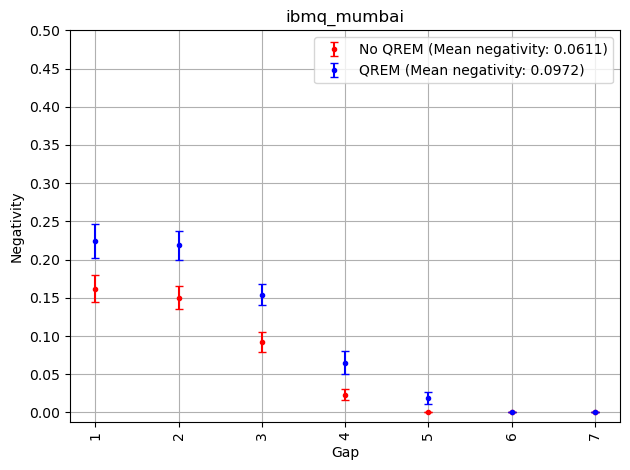

In [12]:
n_list1 = calc_teleported_negativities(rho_dict_list1, post_processing = False, mode='mean')
n_list2 = calc_teleported_negativities(rho_dict_list2, post_processing = False, mode='mean')
n_list3 = calc_teleported_negativities(rho_dict_list3, post_processing = False, mode='mean')
n_list4 = calc_teleported_negativities(rho_dict_list4, post_processing = False, mode='mean')
n_list5 = calc_teleported_negativities(rho_dict_list5, post_processing = False, mode='mean')
n_list6 = calc_teleported_negativities(rho_dict_list6, post_processing = False, mode='mean')
n_list7 = calc_teleported_negativities(rho_dict_list7, post_processing = False, mode='mean')
nmit_list1 = calc_teleported_negativities(rho_dict_list_mit1, post_processing = False, mode='mean')
nmit_list2 = calc_teleported_negativities(rho_dict_list_mit2, post_processing = False, mode='mean')
nmit_list3 = calc_teleported_negativities(rho_dict_list_mit3, post_processing = False, mode='mean')
nmit_list4 = calc_teleported_negativities(rho_dict_list_mit4, post_processing = False, mode='mean')
nmit_list5 = calc_teleported_negativities(rho_dict_list_mit5, post_processing = False, mode='mean')
nmit_list6 = calc_teleported_negativities(rho_dict_list_mit6, post_processing = False, mode='mean')
nmit_list7 = calc_teleported_negativities(rho_dict_list_mit7, post_processing = False, mode='mean')

n_list = []
nmit_list = []
for i in range(4):
    n_list.append(n_list1[i]|n_list2[i]|n_list3[i]|n_list4[i]|n_list5[i]|n_list6[i]|n_list7[i])
for i in range(4):
    nmit_list.append(nmit_list1[i]|nmit_list2[i]|nmit_list3[i]|nmit_list4[i]|nmit_list5[i]|nmit_list6[i]|nmit_list7[i])
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = None)
fig.tight_layout()

In [8]:
#job submission block (split job into pair-basis to prevent memory overflow)
graphstate = Teleportation(backend)
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()

circuits = {gap: {pair: [circuit for circuit in basis_dict.values()] 
                   for pair, basis_dict in pairs_dict.items()} 
             for gap, pairs_dict in graphstate.teleported_BellState_circuits_qst.items()}

circ_list = circuits[1][(0,2)]
circ_list[8].draw()

circ_transpiled = transpile(circ_list, backend = graphstate.backend)
print(len(circ_transpiled))
job = graphstate.backend.run(circ_transpiled, shots = 4096, dynamic = True)

30.0


In [12]:
#job submission block (split job into pair-basis to prevent memory overflow)
import csv

jobs_id = []
jobs_id.append(['jobs','jobs_id'])

graphstate = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()

circuits = {gap: {pair: [circuit for circuit in basis_dict.values()] 
                   for pair, basis_dict in pairs_dict.items()} 
             for gap, pairs_dict in graphstate.teleported_BellState_circuits_qst.items()}

total_circuits = 0
for i in range(4):
    for gap, pairs_dict in circuits.items():
        for pair, circ_list in pairs_dict.items():
            new_circ_list = []
            total_circuits += 9
            for circ in circ_list:
                name_ext = circ.name + f'-{i}'
                circ.name = name_ext
                new_circ_list.append(circ)
            circ_transpiled = transpile(new_circ_list, backend = graphstate.backend)
            print(len(circ_transpiled))
            job = graphstate.backend.run(circ_transpiled, shots = 4096, dynamic = True)
            jobs_id.append([f'{i}-{gap}-{pair}', job.job_id()])
print(total_circuits)
fp = open('Reduced size Dynamic circuits for teleportation of BellState-mumbai-rep4','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

9


c:\Users\k0426\anaconda3\envs\py3-10-4\lib\site-packages\qiskit_ibm_provider\ibm_backend.py:431: UserWarning: The backend ibmq_mumbai is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
1008


In [4]:
#job submission block (split job into pair-basis to prevent memory overflow)
import csv

jobs_id = []
jobs_id.append(['job','jobs_id'])

graphstate = Teleportation(backend, qubits_to_connect = [0,1,4,7,10,12,15,18,21])
graphstate.gen_teleportation_basis()
graphstate.gen_teleported_BellState_circuit(post_processing = False)
graphstate.gen_teleported_qst_circuits()

qrem_circ_list = graphstate.gen_qrem_circuits()
#qrem_circ_list[1].draw()
qrem_cric_transpiled = transpile(qrem_circ_list, backend = graphstate.backend)
job = graphstate.backend.run(qrem_cric_transpiled, shots = 4096)
jobs_id.append(['qrem', job.job_id()])
fp = open('qrem for teleportation of BellState-mumbai2','w')
writer = csv.writer(fp, delimiter='|')
writer.writerows(jobs_id)
fp.close()

c:\Users\k0426\anaconda3\envs\py3-10-4\lib\site-packages\qiskit_ibm_provider\ibm_backend.py:431: UserWarning: The backend ibmq_mumbai is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


In [4]:
import csv
jobs_id = {}
fp = open('Reduced size Dynamic circuits for teleportation of BellState-mumbai-rep4','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        jobs_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(jobs_id)

['0-1-(0, 4)', 'ch961ig1l2f3uq90uffg']
['0-1-(1, 7)', 'ch961io1l2f3uq90ufo0']
['0-1-(4, 10)', 'ch961jc4k9li68o7q1c0']
['0-1-(7, 12)', 'ch961jg1l2f3uq90ug80']
['0-1-(10, 15)', 'ch961k1ccmlc5k9jlni0']
['0-1-(12, 18)', 'ch961kfa54942melh3l0']
['0-1-(15, 21)', 'ch961kpccmlc5k9jlnvg']
['0-2-(0, 7)', 'ch961lfa54942melh45g']
['0-2-(1, 10)', 'ch961lhccmlc5k9jlolg']
['0-2-(4, 12)', 'ch961m44k9li68o7q31g']
['0-2-(7, 15)', 'ch961mbmre35qqphs5bg']
['0-2-(10, 18)', 'ch961mva54942melh550']
['0-2-(12, 21)', 'ch961n4rpl4d0vvv7bk0']
['0-3-(0, 10)', 'ch961nkrpl4d0vvv7c00']
['0-3-(1, 12)', 'ch961o4rpl4d0vvv7ccg']
['0-3-(4, 15)', 'ch961okrpl4d0vvv7cog']
['0-3-(7, 18)', 'ch961p1ccmlc5k9jlrd0']
['0-3-(10, 21)', 'ch961pjmre35qqphs7ug']
['0-4-(0, 12)', 'ch961q1ccmlc5k9jls4g']
['0-4-(1, 15)', 'ch961qg1l2f3uq90ulfg']
['0-4-(4, 18)', 'ch961r01l2f3uq90ulsg']
['0-4-(7, 21)', 'ch961rkrpl4d0vvv7f3g']
['0-5-(0, 15)', 'ch961s44k9li68o7q80g']
['0-5-(1, 18)', 'ch961sg1l2f3uq90unb0']
['0-5-(4, 21)', 'ch961tcrpl4d0vvv7gc0

In [5]:
import csv
qrem_id = {}

fp = open('qrem for teleportation of BellState-mumbai2','r')
reader = csv.reader(fp, delimiter='|')
line_count = 0
for row in reader:
    if line_count > 0 and line_count % 2 == 0:
        print(row)
        qrem_id[row[0]] = row[1]
    line_count += 1
fp.close()
print(qrem_id)

['qrem', 'ch95mikrpl4d0vvv1cb0']
{'qrem': 'ch95mikrpl4d0vvv1cb0'}


In [2]:
job = provider.backend.retrieve_job('cfu4it3mcdu7bt2giu4g')
result = job.result()
job_approx_execution_time = result.time_taken 
print(job_approx_execution_time)

9.235870599746704


Data Analyse section for dynamic circuit 

In [ ]:
time0 = time()

graphstate = Teleportation(backend, qubits_to_connect=[0,1,4,7,10,12,15,18,21])
rho_dict_list = graphstate.recon_teleported_density_mats_from_multi(jobs_id, qrem_id, apply_mit = False)
rho_dict_list_mit = graphstate.recon_teleported_density_mats_from_multi(jobs_id, qrem_id, apply_mit = True)
print(rho_dict_list)
#rho_dict1 = graphstate.recon_teleported_density_mats_from_multi(jobs_id)

time1 = time()
print(f'Time elapsed: {time1 - time0:.2f} s')

n_list = calc_teleported_negativities(rho_dict_list1, post_processing = False, mode='mean')
nmit_list = calc_teleported_negativities(rho_dict_list_mit1, post_processing = False, mode='mean')
print(n_list)
print(nmit_list)
fig = plot_teleported_negativities_multi_gap(backend, n_list, nmit_list, bellstate = None)
fig.tight_layout()

In [17]:
a = '1-2-3'
print(a.split('-'))
print(a)

['1', '2', '3']
1-2-3
